In [1]:
import os
import sys
import absl
import json
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy import stats
import seaborn as sns
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
from time import time
from math import pi
from numba import njit

parentDir = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(os.path.join(os.getcwd(), "general_utils"))
# import file_management
sys.path.append(os.path.join(os.getcwd(), "Model_utils"))
# from plotting_mine import InputActivityFigure, RasterPlot, LaminarPlot, LGN_sample_plot
import load_sparse
import models
import toolkit
import analysis_utils as utils
from scipy.stats import f_oneway
from scipy.optimize import curve_fit
from scipy.stats import f as f_distribution

import h5py
import pickle as pkl
import other_billeh_utils

from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS

sns.set(style="ticks")
plt.rcParams['text.usetex'] = True

/tmp/ipykernel_736236/2274882526.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2025-02-17 17:05:57.868867: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Noise Analysis

In [2]:
results_paths = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Simulation_results/v1_100000_lm_30000/b_86qi_mnist/connected_areas_True_conn_rec_True_conn_noise_True/Noise_analysis'
# iterate over the different noise levels 
noise_levels = [0.01, 0.1, 1.0, 10.0, 100.0]
# load the pickle files containing the results for each noise level. files have the names : validation_results_std_{noise_level}.pkl
accuracy_with_LM = []
for noise_level in noise_levels:
    path = os.path.join(results_paths, f'validation_results_std_{noise_level}.pkl')
    with open(path, 'rb') as f:
        data = pkl.load(f)
        accuracy_with_LM.append(data['validation_results'][0])

In [3]:
accuracy_with_LM

[0.8737, 0.8707, 0.8715, 0.7916, 0.369]

In [4]:
results_paths = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Simulation_results/v1_100000_lm_30000/b_itfr/Noise_analysis'
results_paths = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Simulation_results/v1_100000_lm_30000/b_86qi_mnist/connected_areas_False_conn_rec_True_conn_noise_True/Noise_analysis'
# iterate over the different noise levels 
noise_levels = [0.01, 0.1, 1.0, 10.0, 100.0]
# load the pickle files containing the results for each noise level. files have the names : validation_results_std_{noise_level}.pkl
accuracy_without_LM = []
for noise_level in noise_levels:
    path = os.path.join(results_paths, f'validation_results_std_{noise_level}.pkl')
    with open(path, 'rb') as f:
        data = pkl.load(f)
        accuracy_without_LM.append(data['validation_results'][0])

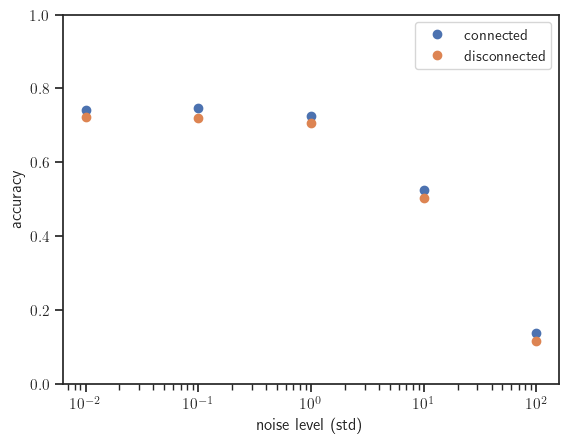

In [41]:
plt.plot(noise_levels, accuracy_with_LM, 'o')
plt.plot(noise_levels, accuracy_without_LM, 'o')
plt.legend(['connected', 'disconnected'])
plt.ylim(0, 1)
plt.xscale('log')
plt.ylabel('accuracy')
plt.xlabel('noise level (std)')
plt.show()

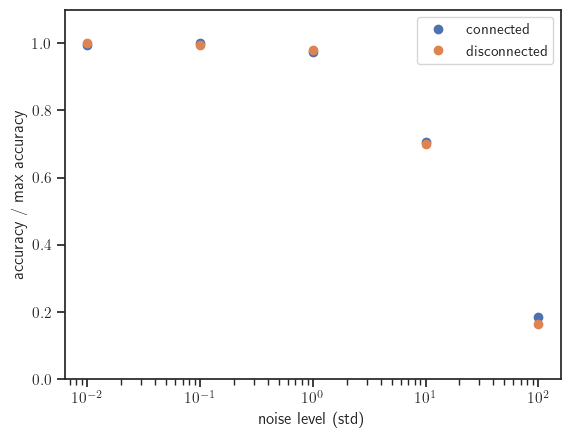

In [42]:
plt.plot(noise_levels, accuracy_with_LM/max(accuracy_with_LM), 'o')
plt.plot(noise_levels, accuracy_without_LM/max(accuracy_without_LM), 'o')
plt.legend(['connected', 'disconnected'])
plt.ylim(0, 1.1)
plt.xscale('log')
plt.ylabel('accuracy / max accuracy')
plt.xlabel('noise level (std)')
plt.show()

In [44]:
# Compute Area Under the Accuracy Curve (AUAC) using the trapezoidal rule
AUAC_with_LM = np.trapz(accuracy_with_LM/max(accuracy_with_LM), noise_levels)
AUAC_without_LM = np.trapz(accuracy_without_LM/max(accuracy_without_LM), noise_levels)

# Compute Noise Tolerance (NT) as the slope of accuracy decline
NT_with_LM = (accuracy_with_LM[-1] - accuracy_with_LM[0]) / (noise_levels[-1] - noise_levels[0])
NT_without_LM = (accuracy_without_LM[-1] - accuracy_without_LM[0]) / (noise_levels[-1] - noise_levels[0])

# Create a DataFrame to display results
results_df = pd.DataFrame({
    "Condition": ["With LM", "Without LM"],
    "AUAC": [AUAC_with_LM, AUAC_without_LM],
    "Noise Tolerance (NT)": [NT_with_LM, NT_without_LM]
})

results_df

,Condition,AUAC,Noise Tolerance (NT)
0,With LM,48.569733,-0.006041
1,Without LM,47.292377,-0.006045


In [2]:
path = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/accumulated_predictions_lm_TD_True_3.pkl'
with open(path, 'rb') as f:
    data = pkl.load(f)

v1_spikes = data['v1_spikes']
lm_spikes = data['lm_spikes']
labels = data['labels']

#merge the first two axis
v1_spikes = v1_spikes.reshape(v1_spikes.shape[0]*v1_spikes.shape[1], -1)
lm_spikes = lm_spikes.reshape(lm_spikes.shape[0]*lm_spikes.shape[1], -1)
labels = labels.reshape(-1)

# convert to rates
v1_spikes = v1_spikes * 1000 / 50
lm_spikes = lm_spikes * 1000 / 50

v1_spikes.shape, labels.shape

((10000, 100000), (10000,))

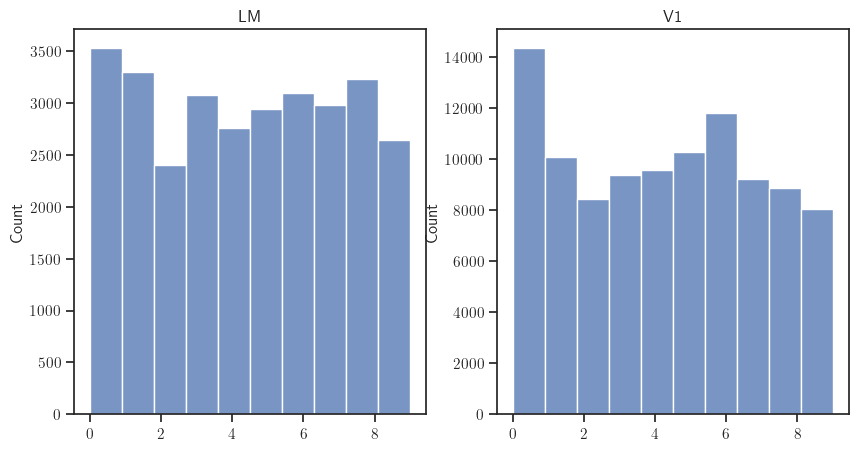

In [3]:
# for each label, compute the average rate of each neuron
lm_activity = np.zeros((10, lm_spikes.shape[1]))
v1_activity = np.zeros((10, v1_spikes.shape[1]))
for i in range(10):
    mask = labels == i
    lm_avg = lm_spikes[mask, :].mean(axis=0)
    v1_avg = v1_spikes[mask, :].mean(axis=0)
    v1_activity[i, :] = v1_avg
    lm_activity[i, :] = lm_avg

# compute the average firing rate of each neuron in the first 1000ms
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# for each neuron, determine the favourite label
lm_favourite_label = np.argmax(lm_activity, axis=0)
v1_favourite_label = np.argmax(v1_activity, axis=0)
# plot the distribution of favourite labels
sns.histplot(lm_favourite_label, bins=10, ax=axs[0])
sns.histplot(v1_favourite_label, bins=10, ax=axs[1])
axs[0].set_title('LM')
axs[1].set_title('V1')

plt.show()

In [3]:
CACHE_PATH = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Model_utils/.cache/lm_v1_network_v1_100000_lm_30000.pkl'
# Load network parameters
with open(CACHE_PATH, 'rb') as f:
    networks, lgn_inputs, bkg_inputs = pkl.load(f)

# ckpt_path = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Simulation_results/v1_100000_lm_30000/b_gvbz/Best_model'
ckpt_path = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Simulation_results/v1_100000_lm_30000/b_qq3w/Best_model'
checkpoint_directory = tf.train.latest_checkpoint(ckpt_path)
print(f'Restoring checkpoint from {checkpoint_directory}...')

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
dtype = tf.float16

# Build the model
model = models.create_model(
    networks, 
    lgn_inputs, 
    bkg_inputs, 
    seq_len=500,
    n_input=17400, 
    dtype=tf.float32, 
    input_weight_scale=1.,
    interarea_weight_scale=1., 
    recurrent_dampening_factor=.1,
    dampening_factor=.1, 
    gauss_std=.3, 
    lr_scale=1.,
    train_recurrent_v1=True, 
    train_recurrent_lm=True, 
    train_input=False, 
    train_interarea_lm_v1=True,
    train_interarea_v1_lm=True,
    train_noise=True,
    batch_size=1, 
    pseudo_gauss=False, 
    use_state_input=True, 
    return_state=True,
    hard_reset=False,
    connected_areas=True,
    add_rate_metric=False, 
    max_delay=5, 
    n_output=10,
    neuron_output=False,
    current_input=False,
    # output_completed_valid_from_time=120, 
    # output_abstract_valid_from_time=100,
    )

model.build((1, 500, 17400))

# Store the initial model variables that are going to be trained
model_variables_dict = {'Initial': {var.name: var.numpy().astype(np.float32) for var in model.trainable_variables}}
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(checkpoint_directory).expect_partial()#.assert_consumed()
model_variables_dict['Restored'] = {var.name: var.numpy().astype(np.float32) for var in model.trainable_variables}
model_variables_dict

Restoring checkpoint from /home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Simulation_results/v1_100000_lm_30000/b_qq3w/Best_model/ckpt-28...
The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


2025-02-15 11:14:19.665014: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


###### COLUMN v1 ######
    > # Recurrent synapses: 29227223
    > # LGN input synapses 1520425
    > # BKG input synapses 400000
> lm to v1 interarea synapses 4886892
###### COLUMN lm ######
    > # Recurrent synapses: 7803467
    > # LGN to lm input synapses 0
    > # BKG input synapses 120000
> v1 to lm interarea synapses 6960372


{'Initial': {'v1_sparse_recurrent_weights:0': array([2.7140473e-12, 5.0207597e-01, 9.4576633e-01, ..., 4.3456054e+00,
         2.1572602e+00, 1.5280019e-13], dtype=float32),
  'v1_rest_of_brain_weights:0': array([0.18912196, 0.18912196, 0.18912196, ..., 0.21199313, 0.21199313,
         0.21199313], dtype=float32),
  'v1_sparse_interarea_weights_lm:0': array([2.0126886e-16, 2.9445528e-06, 5.3784456e-03, ..., 2.9259380e-11,
         2.1844896e-12, 7.3896337e-01], dtype=float32),
  'lm_sparse_recurrent_weights:0': array([3.0033822e+00, 5.5851569e-06, 1.3452921e+00, ..., 1.0169811e-09,
         9.6620383e-08, 1.2865155e-07], dtype=float32),
  'lm_rest_of_brain_weights:0': array([0.15993261, 0.15993261, 0.15993261, ..., 0.16134778, 0.16134778,
         0.16134778], dtype=float32),
  'lm_sparse_interarea_weights_v1:0': array([2.3009937e-07, 8.1218239e-08, 3.2513794e-21, ..., 4.3049450e-14,
         3.9504791e-10, 4.8162219e-19], dtype=float32)},
 'Restored': {'v1_sparse_recurrent_weights:0':

In [5]:
# Calculate the average rate of each output neuron, the predictions and the accuracy
n_output = 10
outputs_10 = []
for i in range(n_output):
    t_output = tf.gather(v1_spikes, networks['v1'][f'readout_neuron_ids_{i}'], axis=1)
    t_output = tf.cast(t_output, tf.float32)
    t_output = tf.reduce_mean(t_output, -1)
    outputs_10.append(t_output)

output = tf.concat(outputs_10, axis=-1)
p_connected = tf.nn.softmax(output, axis=-1) # TensorShape([None, 4, 10])
predicted_classes_connected = tf.cast(tf.argmax(p_connected, axis=-1), dtype=tf.int32).numpy()
correct_predictions_connected = tf.cast(tf.equal(predicted_classes_connected, labels), dtype=tf.float32).numpy()
# correct_predictions_connected = tf.reduce_mean(correct_predictions_connected, axis=0).numpy()
accuracy = tf.reduce_mean(correct_predictions_connected).numpy()
print('Accuracy: %f' % accuracy)

Accuracy: 0.911800


In [4]:
target = 'v1'
source = 'v1'

if source == 'v1':
    spikes = v1_spikes
elif source == 'lm':
    spikes = lm_spikes

if source == target:
    variable_key = f'{target}_sparse_recurrent_weights:0'
    indices = np.copy(networks[target]['synapses']['indices'])
else:
    variable_key = f'{target}_sparse_interarea_weights_{source}:0'
    indices = np.copy(networks[target]['interarea_synapses'][source]['indices'])

# Get the synaptic weights
_params = dict(networks[target]['node_params'])
node_type_ids = networks[target]['node_type_ids']
voltage_scale = _params['V_th'] - _params['E_L']
voltage_scale_node_ids = voltage_scale[node_type_ids[indices[:, 0]]]
initial_value_masked = model_variables_dict['Initial'][variable_key] * voltage_scale_node_ids
synaptic_weights = model_variables_dict['Restored'][variable_key] * voltage_scale_node_ids
# Get the cell types of the presynaptic neurons
source_pop_names = other_billeh_utils.pop_names(networks[source])
source_cell_types = np.array([other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in source_pop_names])
pre_cell_types = source_cell_types[indices[:, 1]]
post_cell_types = source_cell_types[indices[:, 0]]

In [5]:
# print the percentage of weights that are zero after training
print('Percentage of zero weights before training:', np.sum(initial_value_masked == 0) / len(initial_value_masked))
print('Percentage of zero weights after training:', np.sum(synaptic_weights == 0) / len(synaptic_weights))

Percentage of zero weights before training: 0.0034582827112928246
Percentage of zero weights after training: 0.0034582827112928246


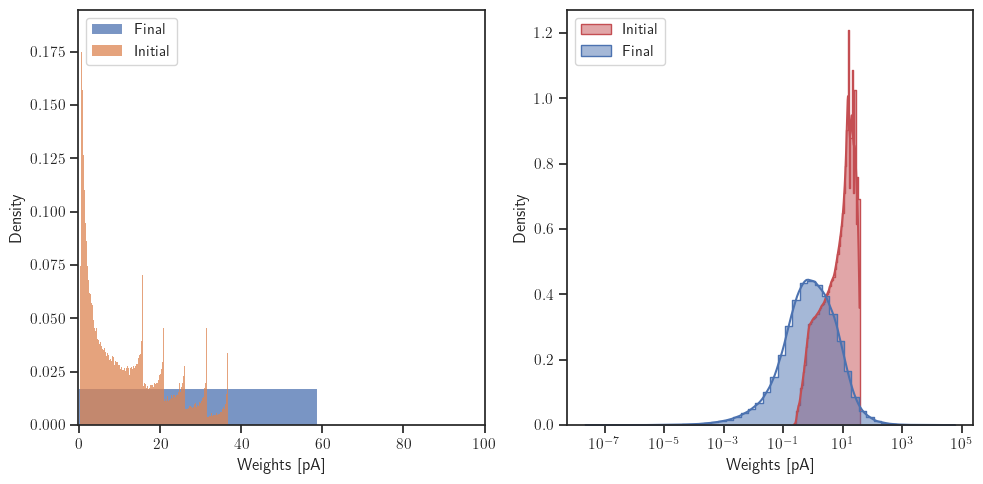

In [7]:
synapses_mask = np.logical_and(pre_cell_types == 'L4 Exc', post_cell_types == 'L4 PV')
initial_weights = np.abs(initial_value_masked[synapses_mask])
final_weights = np.abs(synaptic_weights[synapses_mask])
# positive_weights = final_weights[final_weights > 0]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(final_weights, bins=1000, ax=axs[0], stat='density', label='Final') #, log_scale=True)
sns.histplot(initial_weights, bins=1000, ax=axs[0], stat='density', label='Initial') #, log_scale=True)
sns.histplot(initial_weights, bins=50, kde=True, color='r', alpha=0.5, label="Initial", element='step', log_scale=True, ax=axs[1], stat='density')
sns.histplot(final_weights, bins=50, kde=True, color='b', alpha=0.5, label="Final", element='step', log_scale=True, ax=axs[1], stat='density')
axs[0].set_xlabel('Weights [pA]')
axs[0].set_xlim(-0.2, 100)
axs[0].legend(loc='upper left')
axs[1].legend(loc='upper left')
axs[1].set_xlabel('Weights [pA]')
# axs[1].set_yscale('log')
plt.tight_layout()
plt.show()

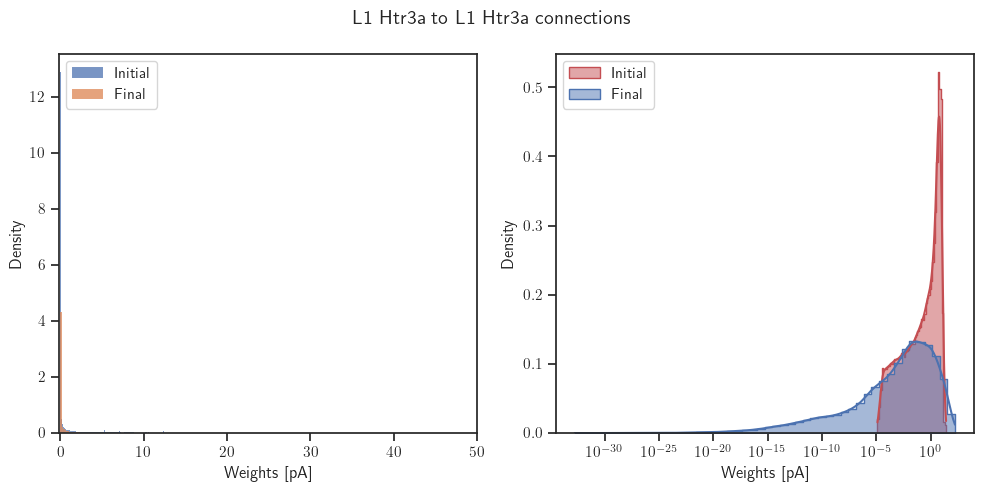

/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


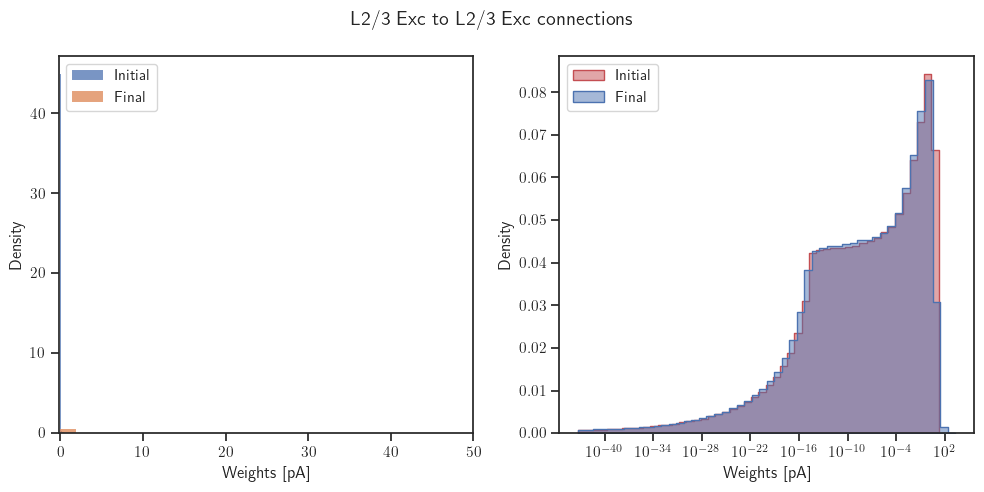

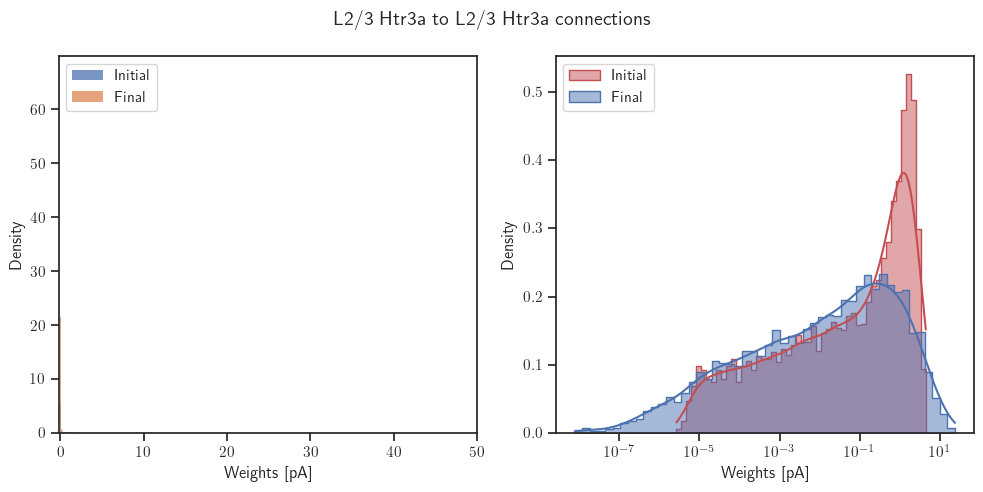

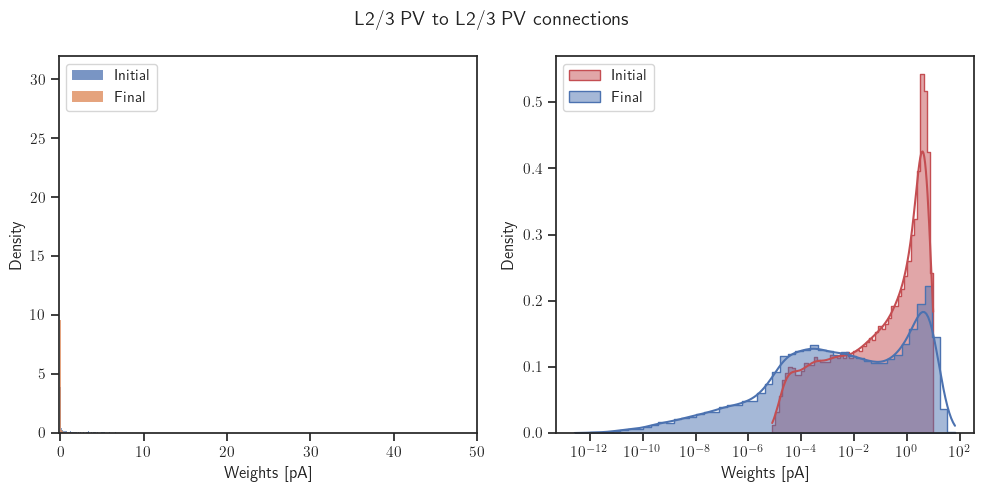

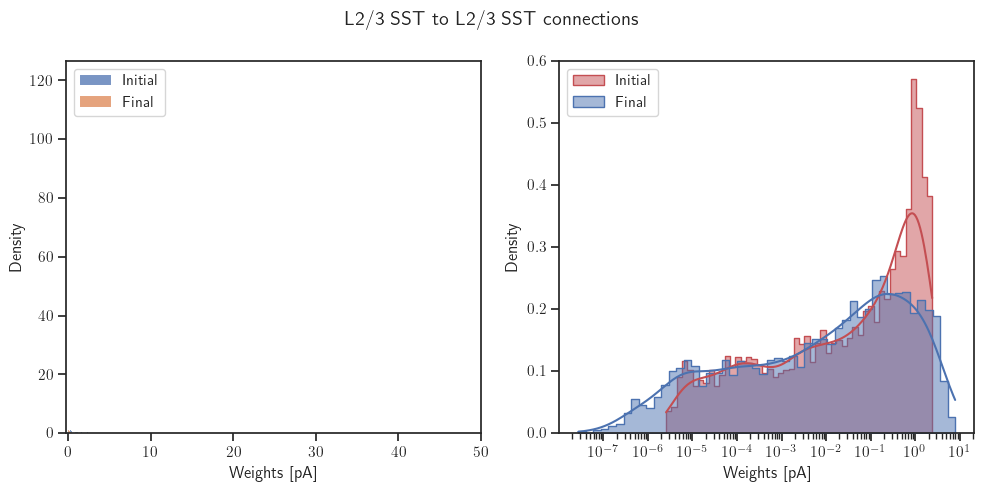

/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


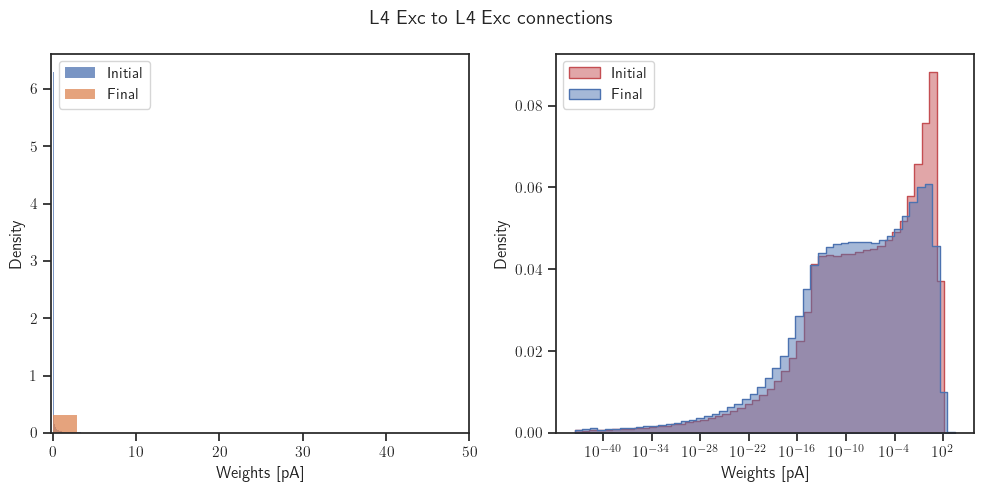

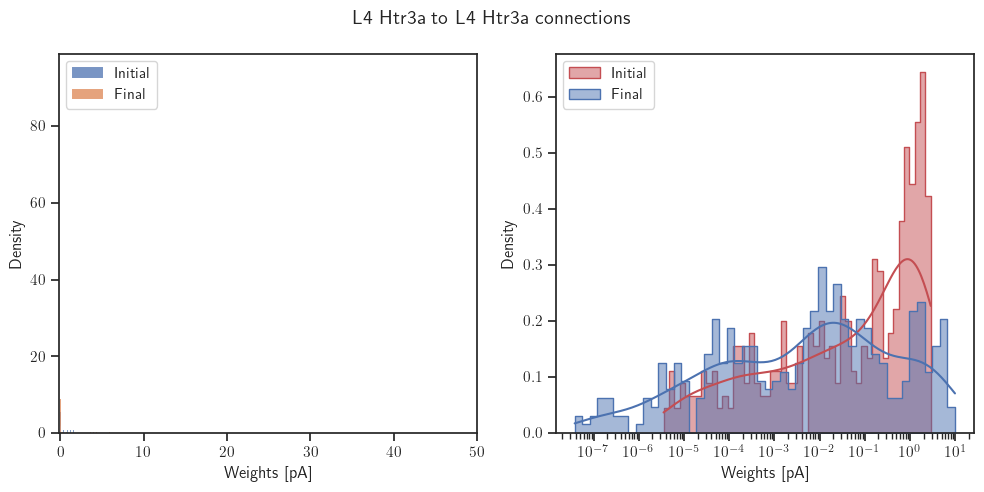

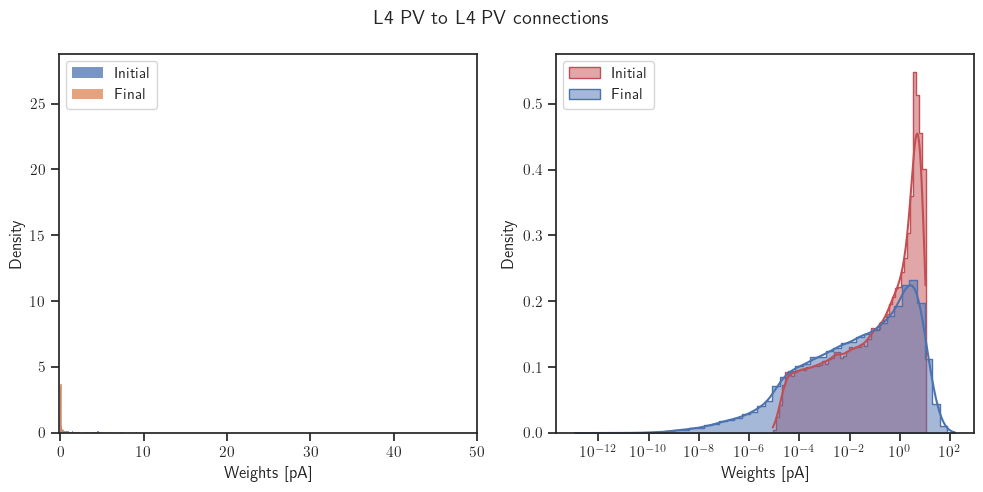

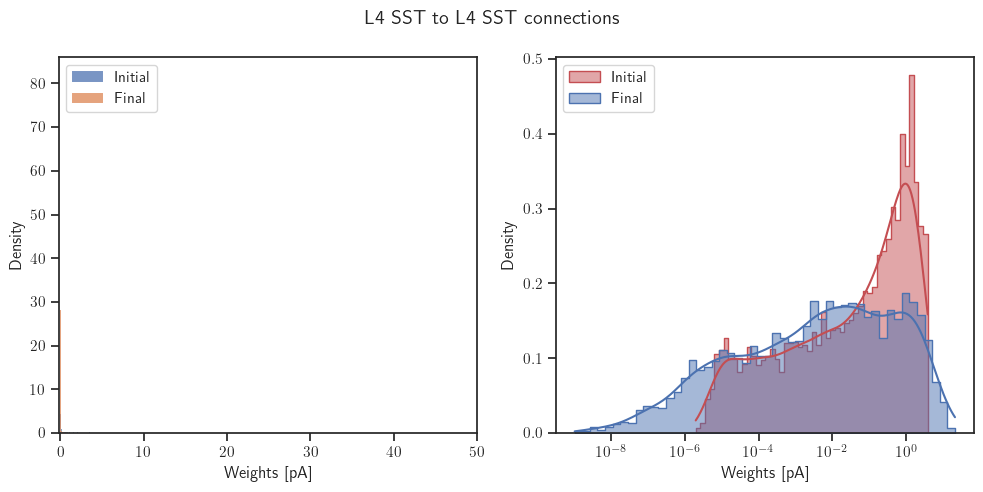

/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


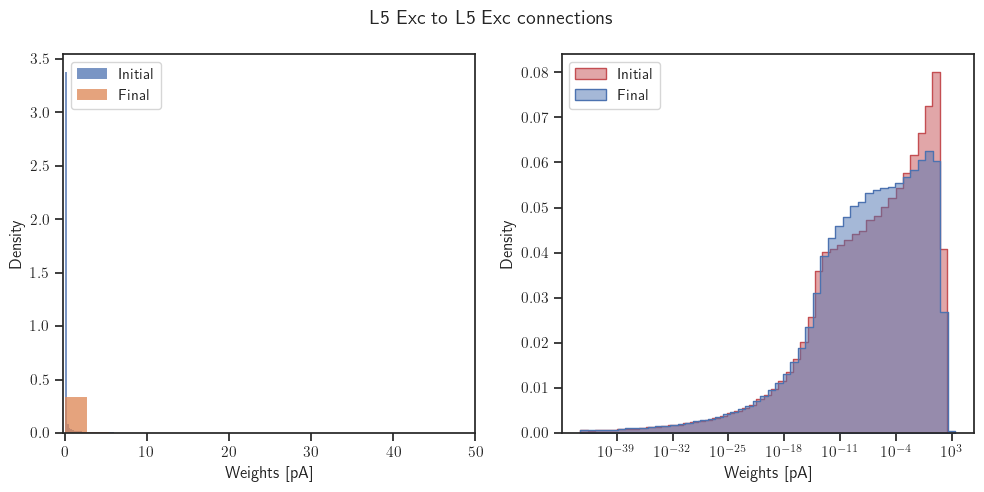

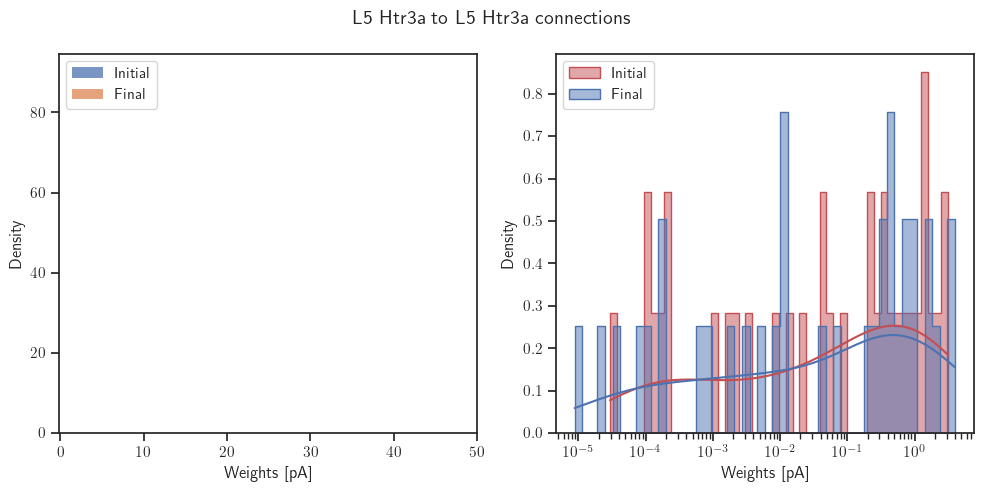

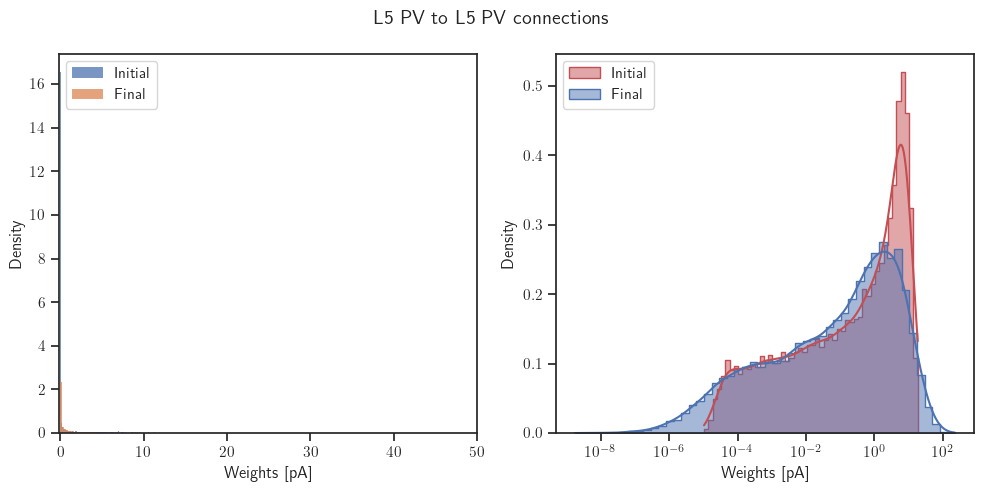

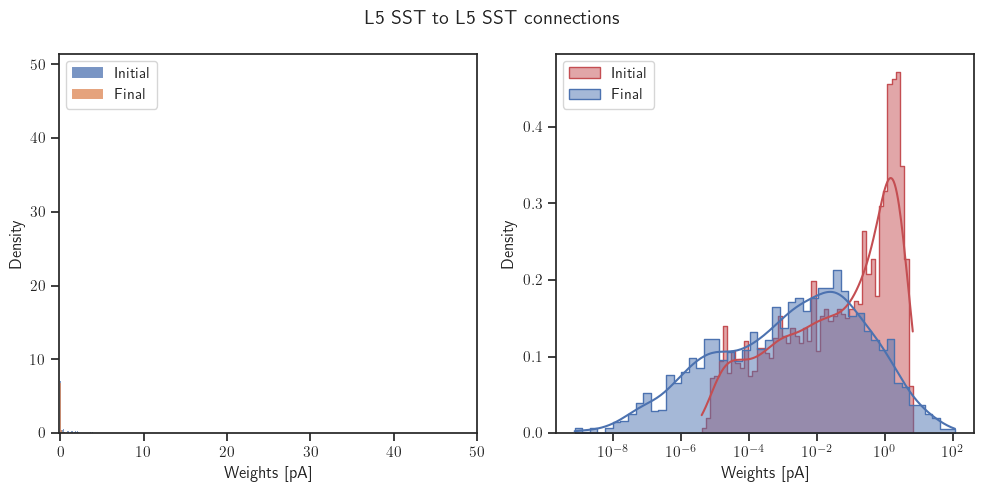

/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


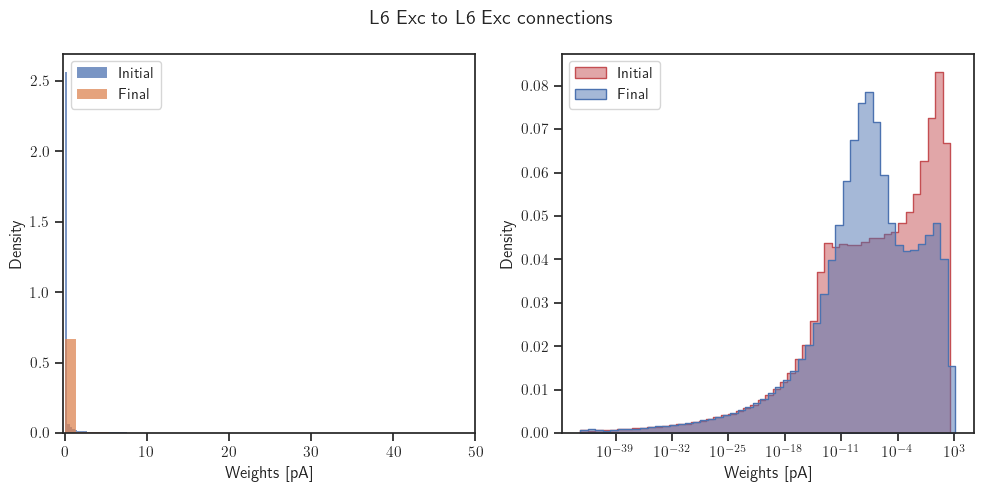

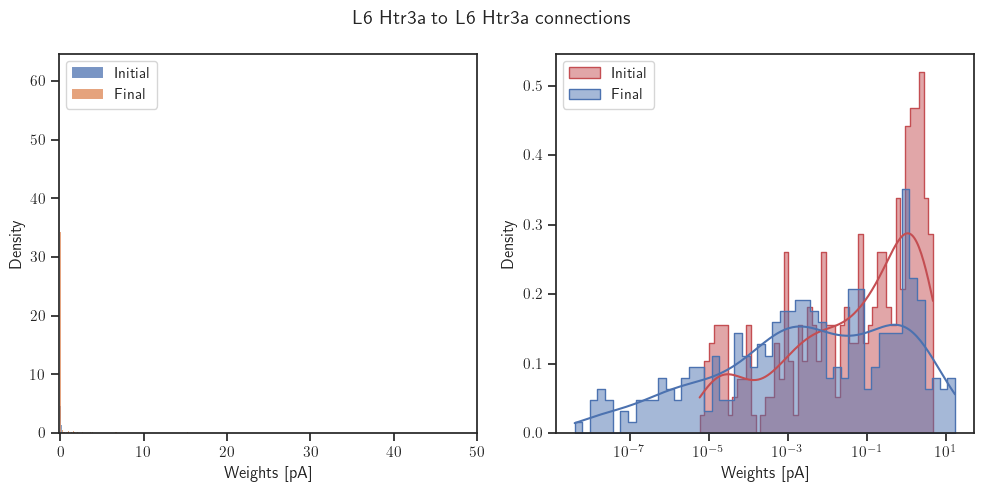

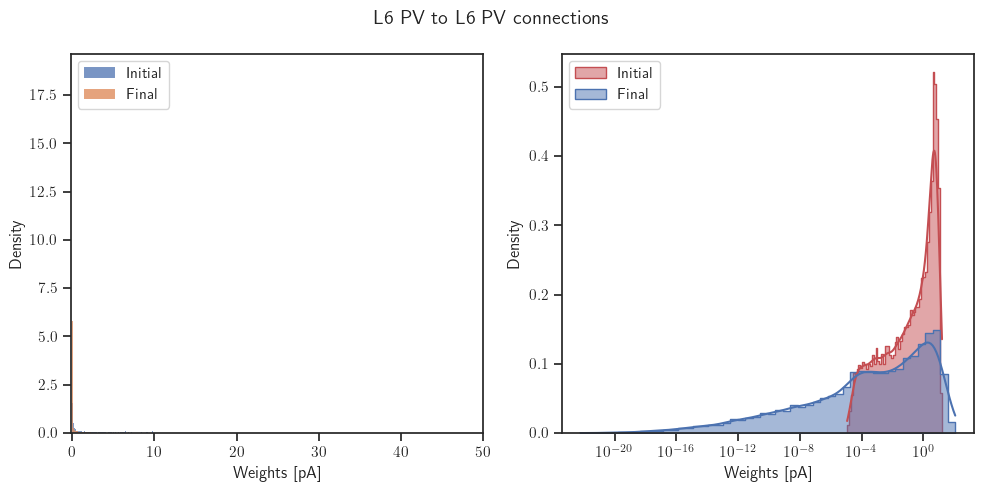

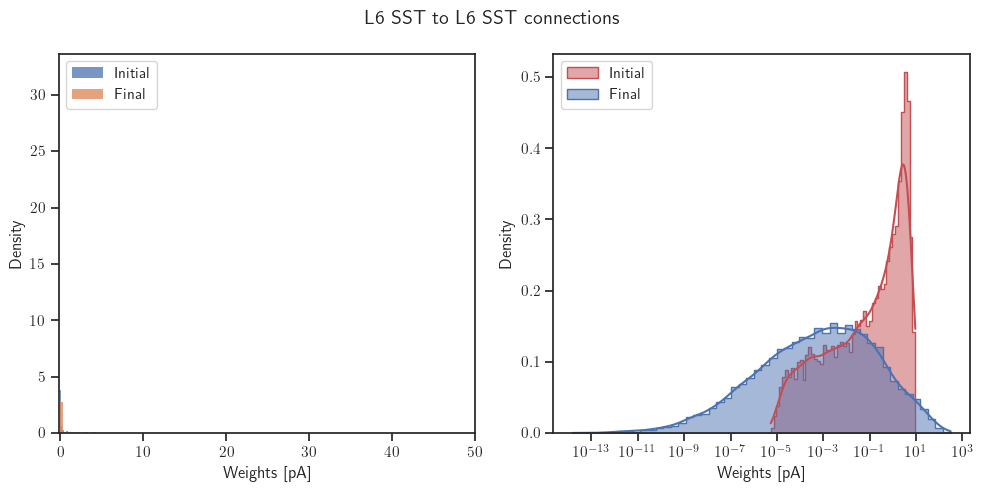

In [8]:
for cell_type in sorted(set(pre_cell_types)):
    synapses_mask = np.logical_and(pre_cell_types == cell_type, post_cell_types == cell_type)
    initial_weights = np.abs(initial_value_masked[synapses_mask])
    final_weights = np.abs(synaptic_weights[synapses_mask])
    # positive_weights = final_weights[final_weights > 0]

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    sns.histplot(initial_weights, bins=1000, ax=axs[0], stat='density', label='Initial') #, log_scale=True)
    sns.histplot(final_weights, bins=1000, ax=axs[0], stat='density', label='Final') #, log_scale=True)
    sns.histplot(initial_weights, bins=50, kde=True, color='r', alpha=0.5, label="Initial", element='step', log_scale=True, ax=axs[1], stat='density')
    sns.histplot(final_weights, bins=50, kde=True, color='b', alpha=0.5, label="Final", element='step', log_scale=True, ax=axs[1], stat='density')
    axs[0].set_xlabel('Weights [pA]')
    axs[0].set_xlim(-0.2, 50)
    axs[0].legend(loc='upper left')
    axs[1].legend(loc='upper left')
    axs[1].set_xlabel('Weights [pA]')
    
    # axs[1].set_yscale('log')
    fig.suptitle(f'{cell_type} to {cell_type} connections')
    plt.tight_layout()
    plt.show()

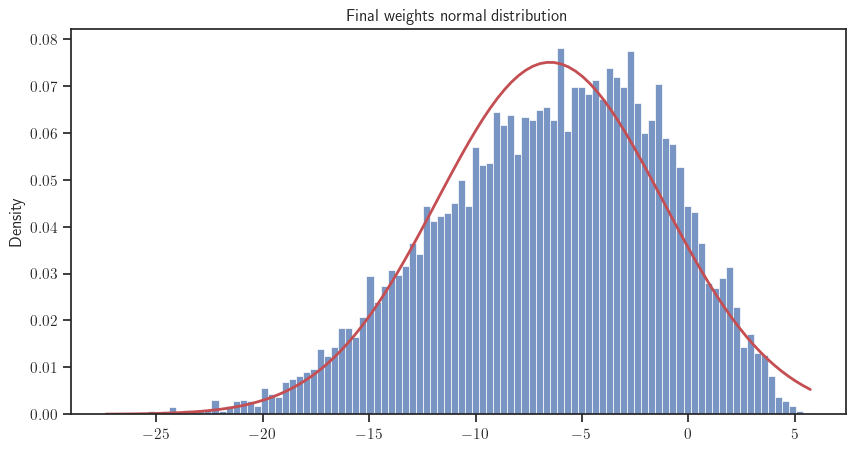

In [11]:
final_weights_log = np.log(final_weights[final_weights > 0])

# plot the histogram of the final weights
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(final_weights_log, bins=100, ax=ax, stat='density')
# fit and plot a normal distribution
mu, sigma = stats.norm.fit(final_weights_log, loc=np.mean(final_weights_log), scale=np.std(final_weights_log))
x = np.linspace(final_weights_log.min(), final_weights_log.max(), 100)
pdf = stats.norm.pdf(x, mu, sigma)
ax.plot(x, pdf, 'r-', lw=2)
ax.set_title('Final weights normal distribution')
plt.show()

In [12]:
# fit a lognormal distribution
shape, loc, scale = stats.lognorm.fit(positive_weights, floc=0)
print(shape, loc, scale)
# plot the fit

NameError: name 'positive_weights' is not defined

In [24]:
min(positive_weights[positive_weights > 0])

2.3951037e-08

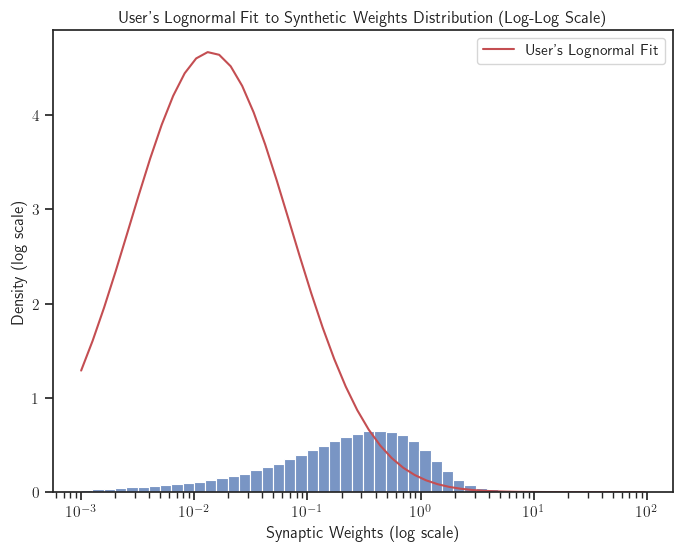

Shape: 1.6341105699539185, Location: 0, Scale: 0.19871653616428375


In [40]:
# Generate synthetic data following a lognormal distribution
# synthetic_weights = np.random.lognormal(mean=0, sigma=1, size=10000)
# synthetic_weights = np.random.lognormal(mean=np.exp(mu), sigma=sigma, size=10000)
synthetic_weights = positive_weights[positive_weights > 1e-3]

# Fit the lognormal distribution
shape, loc, scale = stats.lognorm.fit(synthetic_weights, floc=0)

# Generate values for plotting the fitted distribution
# x_user_fitted = np.linspace(min(synthetic_weights), max(synthetic_weights), 1000)
x_user_fitted = np.logspace(np.log10(min(synthetic_weights)), np.log10(max(synthetic_weights)), 50)
pdf_user_fitted = stats.lognorm.pdf(x_user_fitted, shape, loc, scale)

# Plot the histogram and the fitted lognormal PDF in log-log scale
plt.figure(figsize=(8, 6))
# plt.hist(synthetic_weights, bins=50, density=True, alpha=0.6, color='b', label="Histogram of synthetic weights")
num_bins = 50
log_bins = np.logspace(np.log10(min(synthetic_weights)), np.log10(max(synthetic_weights)), num_bins)
# log_bins = np.linspace(min(synthetic_weights), max(synthetic_weights), num_bins)
sns.histplot(synthetic_weights, bins=num_bins, stat='density', color='b', log_scale=True)
plt.plot(x_user_fitted, pdf_user_fitted, 'r-', label="User's Lognormal Fit")

# Set log scale
plt.xscale("log")
# plt.yscale("log")

plt.xlabel("Synaptic Weights (log scale)")
plt.ylabel("Density (log scale)")
plt.title("User's Lognormal Fit to Synthetic Weights Distribution (Log-Log Scale)")
plt.legend()
plt.show()

# Display fitted parameters
print(f"Shape: {shape}, Location: {loc}, Scale: {scale}")


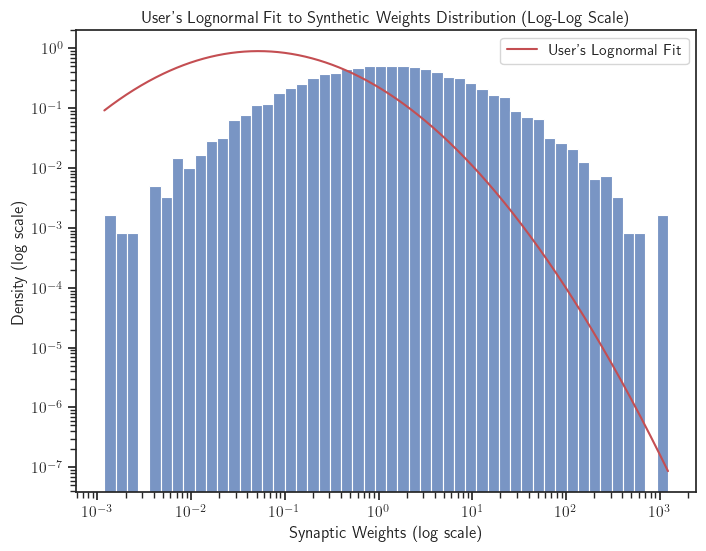

Shape: 1.770163446949734, Location: 0, Scale: 1.1982850247951669


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# Generate synthetic data following a lognormal distribution
np.random.seed(42)  # For reproducibility
# synthetic_weights = np.random.lognormal(mean=0, sigma=1, size=10000)
synthetic_weights = np.random.lognormal(mean=np.exp(mu), sigma=sigma, size=10000)
# synthetic_weights = positive_weights

# Fit the lognormal distribution
shape, loc, scale = lognorm.fit(synthetic_weights, floc=0)

# Generate values for plotting the fitted distribution
# x_user_fitted = np.linspace(min(synthetic_weights), max(synthetic_weights), 1000)
x_user_fitted = np.logspace(np.log10(min(synthetic_weights)), np.log10(max(synthetic_weights)), 1000)

pdf_user_fitted = lognorm.pdf(x_user_fitted, shape, loc, scale)

# Plot the histogram and the fitted lognormal PDF in log-log scale
plt.figure(figsize=(8, 6))
# plt.hist(synthetic_weights, bins=50, density=True, alpha=0.6, color='b', label="Histogram of synthetic weights")
num_bins = 50
log_bins = np.logspace(np.log10(min(synthetic_weights)), np.log10(max(synthetic_weights)), num_bins)
sns.histplot(synthetic_weights, bins=num_bins, stat='density', color='b', log_scale=True)
plt.plot(x_user_fitted, pdf_user_fitted, 'r-', label="User's Lognormal Fit")

# Set log scale
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Synaptic Weights (log scale)")
plt.ylabel("Density (log scale)")
plt.title("User's Lognormal Fit to Synthetic Weights Distribution (Log-Log Scale)")
plt.legend()
plt.show()

# Display fitted parameters
print(f"Shape: {shape}, Location: {loc}, Scale: {scale}")


In [13]:
psp_path = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Neuropixels_data/psp_characterization.csv'
psp_data = pd.read_csv(psp_path, sep=' ')
psp_data[psp_data['pre']=='l23_pyr']

,connection,pre,post,syntype,N_90th,N_resting,mean_90th,mean_resting,median_90th,median_resting,std_90th,std_resting,logn_shape_90th,logn_shape_resting,logn_scale_90th,logn_scale_resting
70,l23_pyr__to__vip,l23_pyr,vip,ex,9,9,1.85987672513863,0.613046150734517,1.85201844699273,0.562375923698523,0.658496299842589,0.448387315999693,0.524391634813887,0.866280545182256,1.67863503421388,0.443197184360619
71,l23_pyr__to__sst,l23_pyr,sst,ex,18,18,1.65852739757129,0.302222225102586,0.98749154306859,0.123681279339567,1.43180022280567,0.436736280586882,0.944402470428765,1.97220202390336,1.1145619243319,0.098277650346315
72,l23_pyr__to__pvalb,l23_pyr,pvalb,ex,18,18,0.627283867677703,0.378410295964478,0.466850529351436,0.223651304956443,0.442870860174603,0.401983269362372,0.477681017656326,0.931265838119063,0.542961155137451,0.243758341913914
73,l23_pyr__to__l6_pyr,l23_pyr,l6_pyr,ex,0,0,[],[],[],[],[],[],[],[],[],[]
74,l23_pyr__to__l5_IT_pyr,l23_pyr,l5_IT_pyr,ex,0,0,[],[],[],[],[],[],[],[],[],[]
75,l23_pyr__to__l5_ET_pyr,l23_pyr,l5_ET_pyr,ex,0,0,[],[],[],[],[],[],[],[],[],[]
76,l23_pyr__to__l4_pyr,l23_pyr,l4_pyr,ex,0,0,[],[],[],[],[],[],[],[],[],[]
77,l23_pyr__to__l23_pyr,l23_pyr,l23_pyr,ex,11,10,0.522461156232853,0.255914540716973,0.294133926595472,0.118853313560774,0.388323097879593,0.273112094129717,0.781140619091607,1.14317727516001,0.390889002620308,0.139361442080847
78,l23_pyr__to__all_pyr,l23_pyr,all_pyr,ex,11,10,0.522461156232853,0.255914540716973,0.294133926595472,0.118853313560774,0.388323097879593,0.273112094129717,0.781140619091607,1.14317727516001,0.390889002620308,0.139361442080847
79,l23_pyr__to__all_int,l23_pyr,all_int,ex,48,48,1.26225511218164,0.412945976592154,0.769055207614604,0.250324147107562,1.09968127024905,0.433157953594768,0.811104725083835,1.52983841644692,0.906651109979451,0.206721771773509


### 1. Data Organization and Basic Descriptives

In [105]:
target = 'v1'
n_output = 10
# source = 'v1'

def get_df(source):
    if source == 'v1':
        spikes = v1_spikes
    elif source == 'lm':
        spikes = lm_spikes

    if source == target:
        variable_key = f'{target}_sparse_recurrent_weights:0'
        indices = np.copy(networks[target]['synapses']['indices'])
    else:
        variable_key = f'{target}_sparse_interarea_weights_{source}:0'
        indices = np.copy(networks[target]['interarea_synapses'][source]['indices'])

    # Get the synaptic weights
    _params = dict(networks[target]['node_params'])
    node_type_ids = networks[target]['node_type_ids']
    voltage_scale = _params['V_th'] - _params['E_L']
    voltage_scale_node_ids = voltage_scale[node_type_ids[indices[:, 0]]]
    # initial_value_masked = model_variables_dict['Initial'][variable_key] * voltage_scale_node_ids
    synaptic_weights = model_variables_dict['Restored'][variable_key] * voltage_scale_node_ids

    # Arrange all the output neurons by clusters
    for i in range(n_output):
        output_ids = networks[target][f'readout_neuron_ids_{i}']
        mask = np.isin(indices[:, 0], output_ids)
        pre_neuron_ids = indices[mask, 1]
        indices[mask, 0] = 100000 + i 
    # drop all the indices whose target indices are not from the output neurons
    mask = indices[:, 0] > 99999
    indices = indices[mask]
    synaptic_weights = synaptic_weights[mask]

    pre_neuron_ids, output_ids = indices[:, 1], indices[:, 0]
    pre_spikes = v1_spikes[:, indices[:, 1]]
    effective_weights = pre_spikes * synaptic_weights[None, :]

    # Get the cell types of the presynaptic neurons
    source_pop_names = other_billeh_utils.pop_names(networks[source])
    source_cell_types = np.array([other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in source_pop_names])
    pre_cell_types = source_cell_types[pre_neuron_ids]

    # Calculate the correct predictions
    correct_mask = correct_predictions_connected == 1	
    incorrect_mask = correct_predictions_connected == 0

    # Select the spike data for samples with label 0
    pre_spikes_correct = pre_spikes[correct_mask, :]  # shape: (n_label0_samples, n_presyn_neurons)
    total_spikes_correct = pre_spikes_correct.mean(axis=0)  # shape: (n_presyn_neurons,)
    effective_weights_correct = effective_weights[correct_mask, :].mean(axis=0)

    pre_spikes_incorrect = pre_spikes[incorrect_mask, :]
    total_spikes_incorrect = pre_spikes_incorrect.mean(axis=0)
    effective_weights_incorrect = effective_weights[incorrect_mask, :].mean(axis=0)

    # CREATE A DF WITH THIS INFORMATION
    df = pd.DataFrame({
        'presynaptic_cell_type': pre_cell_types,
        'total_spikes_correct': total_spikes_correct,
        'total_spikes_incorrect': total_spikes_incorrect,
        'effective_weights_correct': effective_weights_correct,
        'effective_weights_incorrect': effective_weights_incorrect
    })

    # group by cell type and calculate the sum and keep presynaptic cell type as a column
    df = df.groupby('presynaptic_cell_type').sum().reset_index()
    # Add the source as part of the presynaptic cell type
    df['presynaptic_cell_type'] = source + ' ' + df['presynaptic_cell_type']

    df['percentage_change'] = (df['effective_weights_correct'] - df['effective_weights_incorrect'] ) / df['effective_weights_incorrect'] * 100
    df['absolute_change'] = df['effective_weights_correct'] - df['effective_weights_incorrect'] 
    # represent the percentage change
    df['percentage_change'] = df['percentage_change'].round(2)
    df['absolute_change'] = df['absolute_change'].round(2)

    # sort by the absolute change and previously dropa the nan values
    df = df.sort_values('presynaptic_cell_type', ascending=False)

    return df

v1_df = get_df('v1')
lm_df = get_df('lm')

df = pd.concat([v1_df, lm_df])
df

,presynaptic_cell_type,total_spikes_correct,total_spikes_incorrect,effective_weights_correct,effective_weights_incorrect,percentage_change,absolute_change
14,v1 L6 SST,14541.568359,17614.988281,-2.887206e+05,-3.484786e+05,-17.150000,5.975800e+04
13,v1 L6 PV,54293.207031,65024.875000,-1.053816e+06,-1.266393e+06,-16.790001,2.125766e+05
12,v1 L6 Htr3a,1243.274780,1575.079346,-1.815379e+04,-2.291695e+04,-20.780001,4.763160e+03
11,v1 L6 Exc,34180.906250,40049.003906,2.456273e+05,2.956468e+05,-16.920000,-5.001944e+04
10,v1 L5 SST,90315.710938,98577.367188,-2.899198e+06,-3.158767e+06,-8.220000,2.595685e+05
9,v1 L5 PV,188115.218750,209385.765625,-6.859224e+06,-7.553986e+06,-9.200000,6.947620e+05
8,v1 L5 Htr3a,6627.255859,9026.031250,-1.915608e+05,-2.563110e+05,-25.260000,6.475020e+04
7,v1 L5 Exc,245355.656250,319679.687500,4.011257e+06,5.333813e+06,-24.799999,-1.322556e+06
6,v1 L4 SST,2557.942627,2981.882080,-9.955526e+04,-1.165107e+05,-14.550000,1.695543e+04
5,v1 L4 PV,38167.699219,43133.218750,-1.433601e+06,-1.618760e+06,-11.440000,1.851594e+05


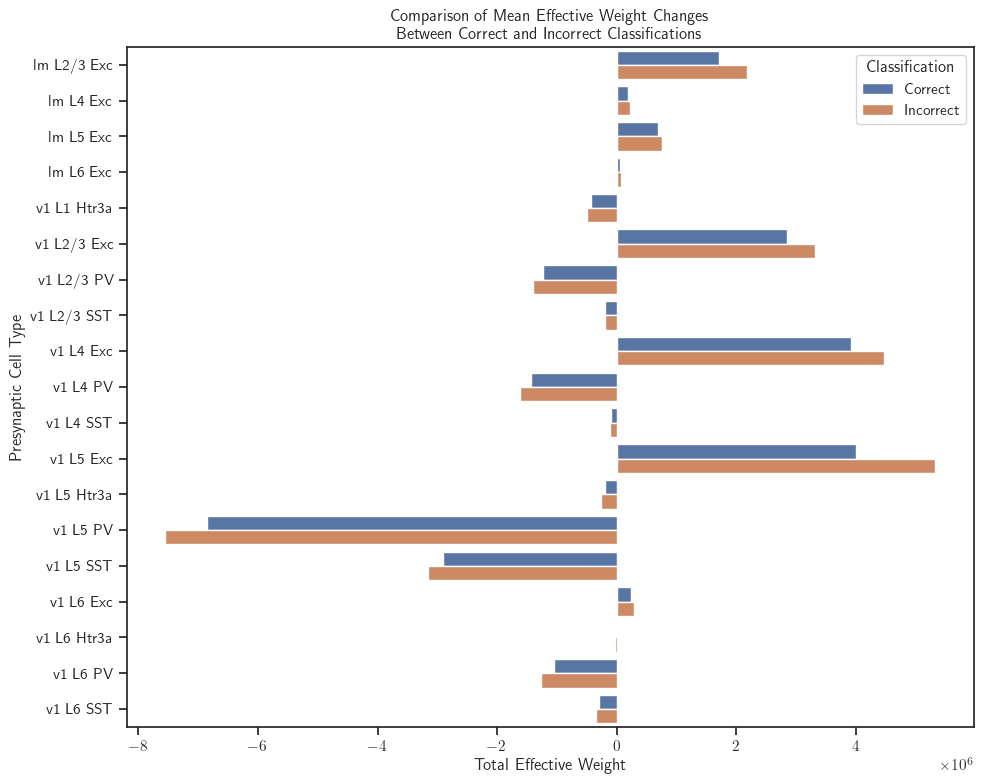

In [106]:
# Sort data by presynaptic cell type
df = df.sort_values('presynaptic_cell_type')
# Set up the figure
plt.figure(figsize=(10, 8))
# Create a grouped bar plot
df_melted = df.melt(id_vars=['presynaptic_cell_type'], 
                     value_vars=['effective_weights_correct', 'effective_weights_incorrect'], 
                     var_name='Classification', 
                     value_name='Effective Weight Change')
# Rename the classification column for clarity
df_melted['Classification'] = df_melted['Classification'].replace({
    'effective_weights_correct': 'Correct',
    'effective_weights_incorrect': 'Incorrect'
})
# Plot
sns.barplot(data=df_melted, y='presynaptic_cell_type', x='Effective Weight Change', 
            hue='Classification', errorbar='sd')
# Labels and title
plt.xlabel('Total Effective Weight')
plt.ylabel('Presynaptic Cell Type')
plt.title('Comparison of Mean Effective Weight Changes\nBetween Correct and Incorrect Classifications')
# Adjust legend
plt.legend(title='Classification')
# Show plot
plt.tight_layout()
plt.show()

In [107]:
df

,presynaptic_cell_type,total_spikes_correct,total_spikes_incorrect,effective_weights_correct,effective_weights_incorrect,percentage_change,absolute_change
0,lm L2/3 Exc,82456.609375,103704.671875,1.718872e+06,2.182494e+06,-21.240000,-4.636221e+05
1,lm L4 Exc,11586.703125,13118.413086,1.959762e+05,2.203312e+05,-11.050000,-2.435506e+04
2,lm L5 Exc,34098.355469,37058.027344,6.970148e+05,7.590034e+05,-8.170000,-6.198856e+04
3,lm L6 Exc,8528.227539,9221.133789,6.404991e+04,6.771060e+04,-5.410000,-3.660690e+03
0,v1 L1 Htr3a,17863.568359,20871.156250,-4.244048e+05,-5.021399e+05,-15.480000,7.773516e+04
1,v1 L2/3 Exc,127353.976562,141253.328125,2.842865e+06,3.316764e+06,-14.290000,-4.738985e+05
2,v1 L2/3 PV,24274.410156,27847.642578,-1.227301e+06,-1.395829e+06,-12.070000,1.685286e+05
3,v1 L2/3 SST,3927.416016,3889.251709,-1.939997e+05,-1.952299e+05,-0.630000,1.230230e+03
4,v1 L4 Exc,198653.375000,222673.921875,3.921220e+06,4.473377e+06,-12.340000,-5.521572e+05
5,v1 L4 PV,38167.699219,43133.218750,-1.433601e+06,-1.618760e+06,-11.440000,1.851594e+05


In [113]:
target = 'v1'
n_output = 10
# source = 'v1'

def get_df(source):
    if source == 'v1':
        spikes = v1_spikes
    elif source == 'lm':
        spikes = lm_spikes

    if source == target:
        variable_key = f'{target}_sparse_recurrent_weights:0'
        indices = np.copy(networks[target]['synapses']['indices'])
    else:
        variable_key = f'{target}_sparse_interarea_weights_{source}:0'
        indices = np.copy(networks[target]['interarea_synapses'][source]['indices'])

    # Get the synaptic weights
    _params = dict(networks[target]['node_params'])
    node_type_ids = networks[target]['node_type_ids']
    voltage_scale = _params['V_th'] - _params['E_L']
    voltage_scale_node_ids = voltage_scale[node_type_ids[indices[:, 0]]]
    # initial_value_masked = model_variables_dict['Initial'][variable_key] * voltage_scale_node_ids
    synaptic_weights = model_variables_dict['Restored'][variable_key] * voltage_scale_node_ids

    # Arrange all the output neurons by clusters
    for i in range(n_output):
        output_ids = networks[target][f'readout_neuron_ids_{i}']
        mask = np.isin(indices[:, 0], output_ids)
        pre_neuron_ids = indices[mask, 1]
        indices[mask, 0] = 100000 + i 
    # drop all the indices whose target indices are not from the output neurons
    mask = indices[:, 0] > 99999
    indices = indices[mask]
    synaptic_weights = synaptic_weights[mask]

    pre_neuron_ids, output_ids = indices[:, 1], indices[:, 0]
    pre_spikes = v1_spikes[:, indices[:, 1]]
    effective_weights = pre_spikes * synaptic_weights[None, :]

    # Get the cell types of the presynaptic neurons
    source_pop_names = other_billeh_utils.pop_names(networks[source])
    source_cell_types = np.array([other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in source_pop_names])
    pre_cell_types = source_cell_types[pre_neuron_ids]

    # Calculate the correct predictions
    correct_mask = correct_predictions_connected == 1	
    incorrect_mask = correct_predictions_connected == 0

    # create a dataframe with some empty columns
    df = pd.DataFrame({
        'presynaptic_cell_type': pre_cell_types,
        'effective_weights_correct': 0,
        'effective_weights_incorrect': 0
    })

    # iterate over the trials
    for i in range(len(labels)):
        labeled_population = labels[i]
        labeled_population_mask = indices[:, 0] == 100000 + labeled_population
        effective_weights_correct = effective_weights[i, labeled_population_mask].mean(axis=0)  # shape: (n_presyn_neurons,)

        # Select the spike data for the current trial
        if correct_mask[i] == True:
            # Add the effective weights to the correct column for each synapse index
            df.loc[df['presynaptic_cell_type'] == pre_cell_types[labeled_population_mask], 'effective_weights_correct'] += effective_weights_correct  # shape: (n_correct_synapses,)
            
        else:
            # Add the effective weights to the incorrect column for each synapse index
            df.loc[df['presynaptic_cell_type'] == pre_cell_types[labeled_population_mask], 'effective_weights_incorrect'] += effective_weights_correct  # shape: (n_incorrect_synapses,)

    # Add the source as part of the presynaptic cell type
    df['presynaptic_cell_type'] = source + ' ' + df['presynaptic_cell_type']
    # sort by the absolute change and previously dropa the nan values
    df = df.sort_values('presynaptic_cell_type', ascending=False)

    return df

v1_df = get_df('v1')
lm_df = get_df('lm')

df = pd.concat([v1_df, lm_df])
df

ValueError: ('Lengths must match to compare', (113438,), (11177,))

In [112]:
df

,effective_weights_correct,effective_weights_incorrect
presynaptic_cell_type,,
lm L2/3 Exc,8.571656e+05,101649.526493
lm L4 Exc,8.571656e+05,101649.526493
lm L5 Exc,8.571656e+05,101649.526493
lm L6 Exc,8.571656e+05,101649.526493
v1 L1 Htr3a,3.712099e+06,103215.879141
v1 L2/3 Exc,3.712099e+06,103215.879141
v1 L2/3 PV,3.712099e+06,103215.879141
v1 L2/3 SST,3.712099e+06,103215.879141
v1 L4 Exc,3.712099e+06,103215.879141


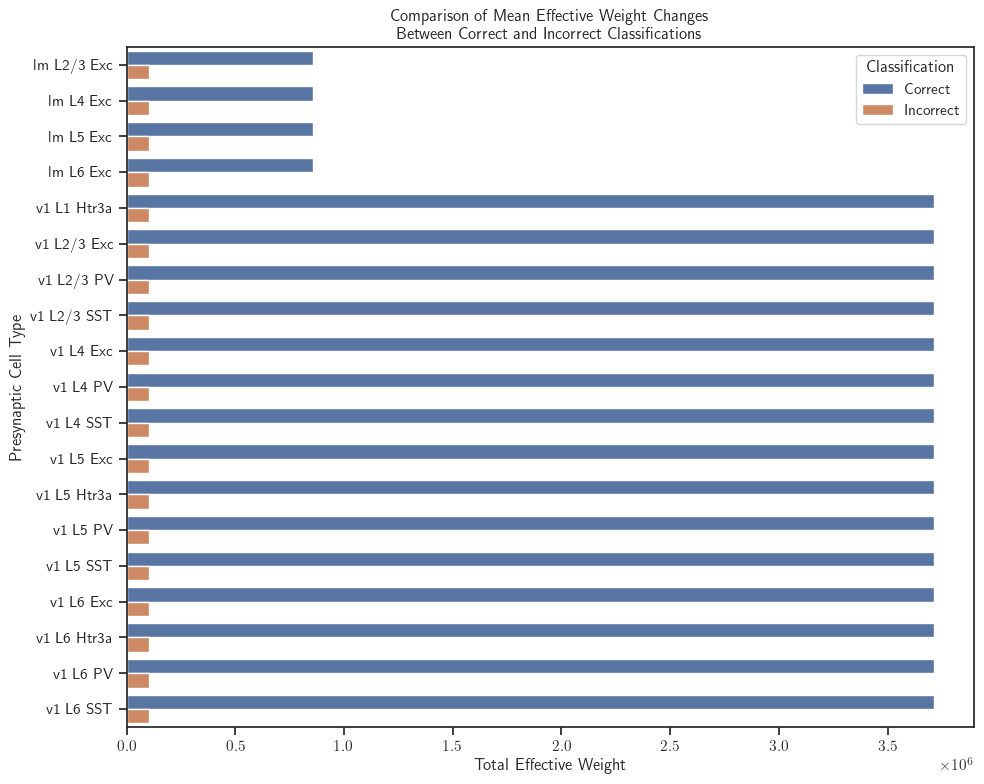

In [111]:
# Sort data by presynaptic cell type
df = df.sort_values('presynaptic_cell_type')
# Set up the figure
plt.figure(figsize=(10, 8))
# Create a grouped bar plot
df_melted = df.melt(id_vars=['presynaptic_cell_type'], 
                     value_vars=['effective_weights_correct', 'effective_weights_incorrect'], 
                     var_name='Classification', 
                     value_name='Effective Weight Change')
# Rename the classification column for clarity
df_melted['Classification'] = df_melted['Classification'].replace({
    'effective_weights_correct': 'Correct',
    'effective_weights_incorrect': 'Incorrect'
})
# Plot
sns.barplot(data=df_melted, y='presynaptic_cell_type', x='Effective Weight Change', 
            hue='Classification', errorbar='sd')
# Labels and title
plt.xlabel('Total Effective Weight')
plt.ylabel('Presynaptic Cell Type')
plt.title('Comparison of Mean Effective Weight Changes\nBetween Correct and Incorrect Classifications')
# Adjust legend
plt.legend(title='Classification')
# Show plot
plt.tight_layout()
plt.show()

### 2. Relating Currents to Accuracy

In [17]:
predicted_classes_connected, correct_predictions_connected

(array([2, 7, 2, ..., 1, 0, 4], dtype=int32),
 array([1., 1., 1., ..., 0., 1., 1.], dtype=float32))

In [53]:
# calculate the total effective weight the winning population receives from LM in each trial
# for each trial, calculate the total effective weight the winning population receives from LM
source = 'lm'
target = 'v1'

if source == target:
    variable_key = f'{target}_sparse_recurrent_weights:0'
    indices = np.copy(networks[target]['synapses']['indices'])
else:
    variable_key = f'{target}_sparse_interarea_weights_{source}:0'
    indices = np.copy(networks[target]['interarea_synapses'][source]['indices'])

# Get the synaptic weights
_params = dict(networks[target]['node_params'])
node_type_ids = networks[target]['node_type_ids']
voltage_scale = _params['V_th'] - _params['E_L']
voltage_scale_node_ids = voltage_scale[node_type_ids[indices[:, 0]]]
# initial_value_masked = model_variables_dict['Initial'][variable_key] * voltage_scale_node_ids
synaptic_weights = model_variables_dict['Restored'][variable_key] * voltage_scale_node_ids

# Arrange all the output neurons by clusters
for i in range(n_output):
    output_ids = networks[target][f'readout_neuron_ids_{i}']
    mask = np.isin(indices[:, 0], output_ids)
    pre_neuron_ids = indices[mask, 1]
    indices[mask, 0] = 100000 + i 
# drop all the indices whose target indices are not from the output neurons
mask = indices[:, 0] > 99999
indices = indices[mask]
synaptic_weights = synaptic_weights[mask]

pre_neuron_ids, output_ids = indices[:, 1], indices[:, 0]
pre_spikes = v1_spikes[:, indices[:, 1]]
effective_weights = pre_spikes * synaptic_weights[None, :]

# Get the cell types of the presynaptic neurons
source_pop_names = other_billeh_utils.pop_names(networks[source])
source_cell_types = np.array([other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in source_pop_names])
pre_cell_types = source_cell_types[pre_neuron_ids]

lm_total_weights = []
for trial in range(len(labels)):
    winning_population = predicted_classes_connected[trial]
    winning_mask = indices[:, 0] == 100000 + winning_population
    total_effective_weight = effective_weights[trial, winning_mask].sum()
    # total_effective_weight = effective_weights[trial, :].sum()
    lm_total_weights.append(total_effective_weight)

lm_total_weights = np.array(lm_total_weights)
lm_total_weights

array([292255.94, 195823.  , 156030.47, ..., 258468.05, 383884.53,
       282813.94], dtype=float32)

In [54]:
# calculate the correlation between lm_total_weights and correct_predictions_connected
correlation_coef, p_value = stats.pearsonr(lm_total_weights, correct_predictions_connected)
correlation_coef, p_value

(-0.1660485970149987, 9.535282677007821e-63)

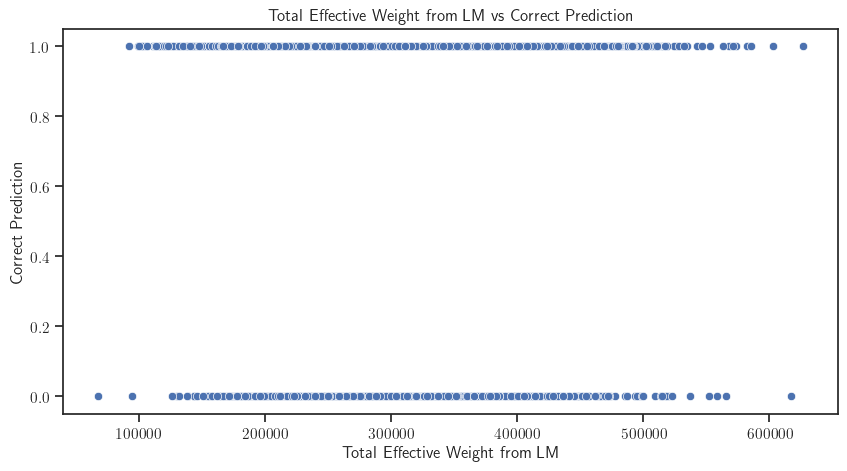

In [63]:
# plot the lm_total_weights vs the correct predictions
plt.figure(figsize=(10, 5))
sns.scatterplot(x=lm_total_weights, y=correct_predictions_connected)
plt.xlabel('Total Effective Weight from LM')
plt.ylabel('Correct Prediction')
plt.title('Total Effective Weight from LM vs Correct Prediction')
plt.show()

In [55]:
# pick up the probability of the predicted classes using numpy
predicted_probabilities = p_connected.numpy()[np.arange(len(labels)), predicted_classes_connected]
# calculate the correlation between the predicted probabilities and correct_predictions_connected
correlation_coef, p_value = stats.pearsonr(lm_total_weights, predicted_probabilities)
correlation_coef, p_value

(-0.05000089516628117, 5.656412891210633e-07)

In [76]:
# Define the “margin of victory” for each trial as the difference between the firing rate (or net spiking output) of the correct population and the second-best population.
# for each trial, calculate the margin of victory
margin_of_victory = []
lm_total_weights = []
for trial in range(len(labels)):
    correct_population = labels[trial]
    prediction = predicted_classes_connected[trial]
    if correct_population == prediction:
        correct_mask = indices[:, 0] == 100000 + correct_population
        correct_fr = output.numpy()[trial, correct_population]
        second_best_population = np.argsort(output.numpy()[trial, :])[::-1][1]
        second_best_fr = output.numpy()[trial, second_best_population]
        margin_of_victory.append(correct_fr - second_best_fr)

        # total_effective_weight = effective_weights[trial, correct_mask].sum()
        total_effective_weight = effective_weights[trial, :].sum()
        lm_total_weights.append(total_effective_weight)

margin_of_victory = np.array(margin_of_victory)
margin_of_victory

array([  2.6666718, 241.33333  , 209.33333  , ...,  54.       ,
       200.       , 205.33333  ], dtype=float32)

In [77]:
# calculate the correlation between lm_total_weights and correct_predictions_connected
correlation_coef, p_value = stats.pearsonr(lm_total_weights, margin_of_victory)
correlation_coef, p_value

(-0.5074998697019614, 0.0)

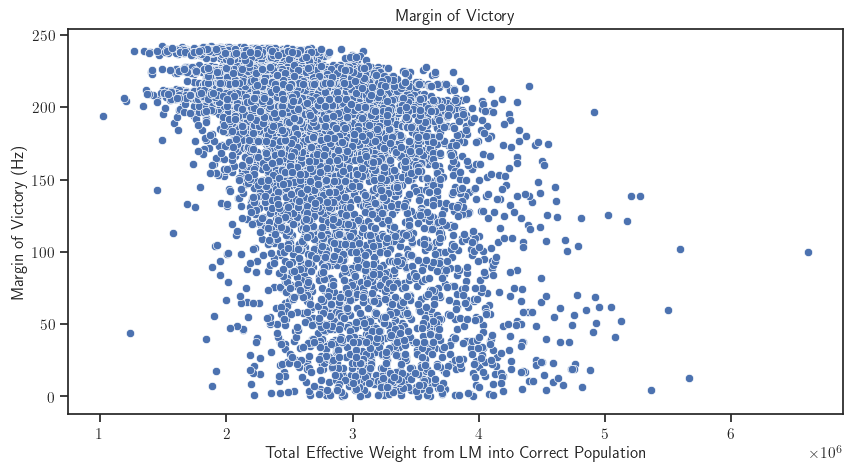

In [78]:
# plot the lm_total_weights vs the correct predictions
plt.figure(figsize=(10, 5))
sns.scatterplot(x=lm_total_weights, y=margin_of_victory)
plt.xlabel('Total Effective Weight from LM into Correct Population')
plt.ylabel('Margin of Victory (Hz)')
plt.title('Margin of Victory')
plt.show()

### 3. Investigating Close Calls

In [87]:
# Define the “margin of victory” for each trial as the difference between the firing rate (or net spiking output) of the correct population and the second-best population.
# for each trial, calculate the margin of victory
# delta = 50
deltas = np.arange(0, 200, 12)
lm_effective_margin = []
for delta in deltas:
    margin_of_victory = []
    lm_delta_weights = []
    for trial in range(len(labels)):
        correct_population = labels[trial]
        prediction = predicted_classes_connected[trial]
        if correct_population == prediction:
            correct_mask = indices[:, 0] == 100000 + correct_population
            correct_fr = output.numpy()[trial, correct_population]
            second_best_population = np.argsort(output.numpy()[trial, :])[::-1][1]
            second_best_fr = output.numpy()[trial, second_best_population]

            win_margin = correct_fr - second_best_fr
            if win_margin > delta and win_margin < delta + 10:
                first_effective_weight = effective_weights[trial, correct_mask].sum()
                second_population_mask = indices[:, 0] == 100000 + second_best_population
                second_effective_weight = effective_weights[trial, second_population_mask].sum()
                delta_weight = first_effective_weight - second_effective_weight

                margin_of_victory.append(win_margin)
                lm_delta_weights.append(delta_weight)

    margin_of_victory = np.array(margin_of_victory)
    lm_delta_weights = np.array(lm_delta_weights)

    lm_effective_margin.append(np.mean(lm_delta_weights))

margin_of_victory.shape

(1141,)

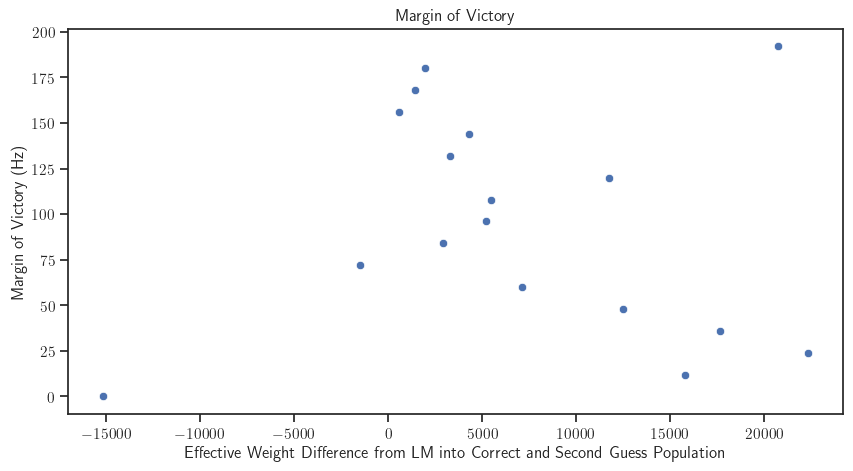

In [88]:
# plot the lm_total_weights vs the correct predictions
plt.figure(figsize=(10, 5))
sns.scatterplot(x=lm_effective_margin, y=deltas)
plt.xlabel('Effective Weight Difference from LM into Correct and Second Guess Population')
plt.ylabel('Margin of Victory (Hz)')
plt.title('Margin of Victory')
plt.show()

In [95]:
# Define the “margin of victory” for each trial as the difference between the firing rate (or net spiking output) of the correct population and the second-best population.
# for each trial, calculate the margin of victory
# delta = 50
deltas = - np.arange(0, 200, 20)
lm_effective_margin = []
for delta in deltas:
    margin_of_victory = []
    lm_delta_weights = []
    for trial in range(len(labels)):
        correct_population = labels[trial]
        prediction = predicted_classes_connected[trial]
        if correct_population != prediction:
            correct_mask = indices[:, 0] == 100000 + correct_population
            correct_fr = output.numpy()[trial, correct_population]
            second_best_population = np.argsort(output.numpy()[trial, :])[::-1][1]
            second_best_fr = output.numpy()[trial, second_best_population]

            win_margin = correct_fr - second_best_fr
            if win_margin > delta and win_margin < delta + 10:
                first_effective_weight = effective_weights[trial, correct_mask].sum()
                second_population_mask = indices[:, 0] == 100000 + second_best_population
                second_effective_weight = effective_weights[trial, second_population_mask].sum()
                delta_weight = first_effective_weight - second_effective_weight

                margin_of_victory.append(win_margin)
                lm_delta_weights.append(delta_weight)

    margin_of_victory = np.array(margin_of_victory)
    lm_delta_weights = np.array(lm_delta_weights)

    lm_effective_margin.append(np.mean(lm_delta_weights))

margin_of_victory.shape

/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(6,)

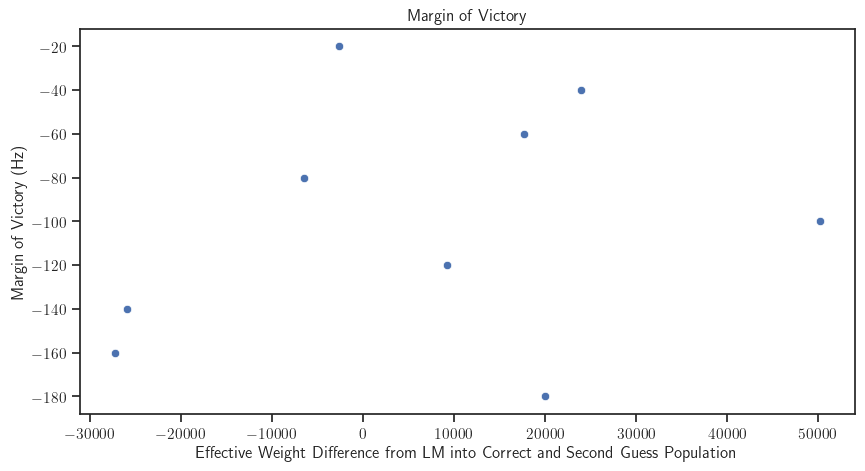

In [96]:
# plot the lm_total_weights vs the correct predictions
plt.figure(figsize=(10, 5))
sns.scatterplot(x=lm_effective_margin, y=deltas)
plt.xlabel('Effective Weight Difference from LM into Correct and Second Guess Population')
plt.ylabel('Margin of Victory (Hz)')
plt.title('Margin of Victory')
plt.show()

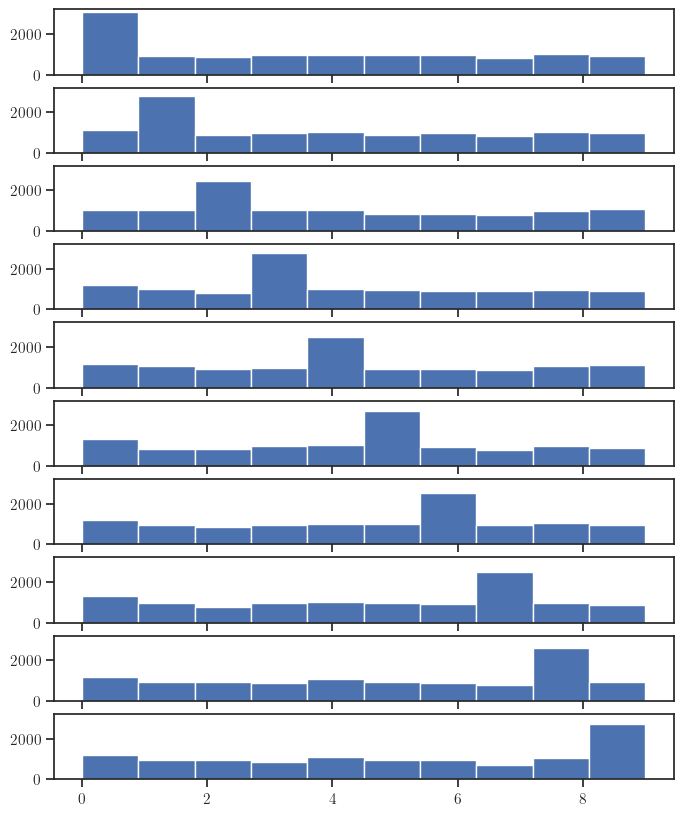

In [45]:
fig, axs = plt.subplots(10, 1, figsize=(8, 10), sharex=True, sharey=True)
axs = axs.flatten()

for i in range(n_output):
    output_ids = networks[target][f'readout_neuron_ids_{i}']
    mask = np.isin(indices[:, 0], output_ids)
    pre_neuron_ids = indices[mask, 1]

    axs[i].hist(v1_favourite_label[pre_neuron_ids], bins=10)
plt.show()

In [54]:
source_pop_names = other_billeh_utils.pop_names(networks[source])
source_cell_types = np.array([other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in source_pop_names])

# fig, axs = plt.subplots(10, 1, figsize=(8, 50), sharex=True)
# axs = axs.flatten()

# for i in range(n_output):
i = 4
# output_ids = networks[target][f'readout_neuron_ids_{i}']
output_id = 100000 + i
# mask = np.isin(indices[:, 0], output_ids)
mask = indices[:, 0] == output_id
# pre_neuron_ids = indices[mask, 1]
pre_neuron_ids = indices[:, 1]
post_neuron_ids = indices[mask, 0]
selected_weights = synaptic_weights[mask]
pre_cell_types = source_cell_types[pre_neuron_ids]

pre_spikes = v1_spikes[:, pre_neuron_ids]
effective_weights_i = effective_weights[:, mask]

# labels_i_mask = labels == i
# labels_not_i_mask = labels != i
labels_i_mask = correct_predictions_connected == 1	
labels_not_i_mask = correct_predictions_connected == 0

# Select the spike data for samples with label 0
pre_spikes_label = pre_spikes[labels_i_mask, :]  # shape: (n_label0_samples, n_presyn_neurons)
# Sum spikes over samples for each presynaptic neuron
total_spikes_label = pre_spikes_label.mean(axis=0)  # shape: (n_presyn_neurons,)
effective_weights_label = effective_weights[labels_i_mask, :].mean(axis=0)

pre_spikes_not_label = pre_spikes[labels_not_i_mask, :]
total_spikes_not_label = pre_spikes_not_label.mean(axis=0)
effective_weights_not_label = effective_weights[labels_not_i_mask, :].mean(axis=0)

# CREATE A DF WITH THIS INFORMATION
df = pd.DataFrame({
    'presynaptic_cell_type': pre_cell_types,
    'total_spikes_i': total_spikes_label,
    'total_spikes_not_i': total_spikes_not_label,
    'effective_weights_i': effective_weights_label,
    'effective_weights_not_i': effective_weights_not_label
})

# group by cell type and calculate the sum and keep presynaptic cell type as a column
df = df.groupby('presynaptic_cell_type').sum().reset_index()
# Add the source as part of the presynaptic cell type
df['presynaptic_cell_type'] = source + ' ' + df['presynaptic_cell_type']

# groupby cell type and calculate the mean
# df = df.groupby('presynaptic_cell_type').sum()
# calculate the percentage of change between the two conditions
df['percentage_change'] = (df['effective_weights_i'] - df['effective_weights_not_i'] ) / df['effective_weights_not_i'] * 100
df['absolute_change'] = df['effective_weights_i'] - df['effective_weights_not_i'] 
# represent the percentage change
df['percentage_change'] = df['percentage_change'].round(2)
df['absolute_change'] = df['absolute_change'].round(2)

# sort by the absolute change and previously dropa the nan values
df = df.dropna()
df = df.sort_values('percentage_change', ascending=False)

# plot the absolute change between the two conditions with the distributions for each cell type
df = df.sort_values('presynaptic_cell_type')
sns.boxplot(data=df, y='presynaptic_cell_type', x='absolute_change', ax=axs[i])
# sort by cell type
axs[i].set_xlabel(f'Absolute change in effective weight (label {i} vs. not {i})')
axs[i].set_ylabel('Presynaptic cell type')
axs[i].set_title(f'Absolute change in effective weights between label {i} and not {i}')

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

## Computational Analysis

In [161]:
def get_spikes_labels(path=''):
    with open(path, 'rb') as f:
        data = pkl.load(f)
    spikes = data['predictions']
    labels = data['labels']
    # concatenate the first two axis
    # spikes = tf.reshape(spikes, (spikes.shape[0]*spikes.shape[1], spikes.shape[2]))
    spikes = tf.reshape(spikes, (spikes.shape[0]*spikes.shape[1], spikes.shape[2], spikes.shape[3]))
    # spikes = tf.nn.softmax(spikes, axis=-1) # TensorShape([None, 4, 10])
    labels = tf.reshape(labels, (labels.shape[0]*labels.shape[1]))
    spikes = spikes.numpy()
    labels = labels.numpy()
    return spikes, labels

In [162]:
disconnected_path = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/accumulated_predictions_lm_TD_False_2.pkl'
spikes_disconnected, labels_disconnected = get_spikes_labels(disconnected_path)

connected_path = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/accumulated_predictions_lm_TD_True_2.pkl'
spikes_connected, labels_connected = get_spikes_labels(connected_path)

In [163]:
spikes_connected.shape, spikes_disconnected.shape

((10000, 20, 10), (10000, 20, 10))

In [164]:
p_connected = tf.nn.softmax(spikes_connected, axis=-1) # TensorShape([None, 4, 10])
p_disconnected = tf.nn.softmax(spikes_disconnected, axis=-1) # TensorShape([None, 4, 10])

# repeat the labels 20 times in an extra dimension
_labels_connected = np.repeat(labels_connected[:, np.newaxis], 20, axis=1)
_labels_disconnected = np.repeat(labels_disconnected[:, np.newaxis], 20, axis=1)

predicted_classes_connected = tf.cast(tf.argmax(p_connected, axis=-1), dtype=tf.int32)
predicted_classes_disconnected = tf.cast(tf.argmax(p_disconnected, axis=-1), dtype=tf.int32)

correct_predictions_connected = tf.cast(tf.equal(predicted_classes_connected, _labels_connected), dtype=tf.float32)
correct_predictions_disconnected = tf.cast(tf.equal(predicted_classes_disconnected, _labels_disconnected), dtype=tf.float32)

correct_predictions_connected = tf.reduce_mean(correct_predictions_connected, axis=0).numpy()
correct_predictions_disconnected = tf.reduce_mean(correct_predictions_disconnected, axis=0).numpy()

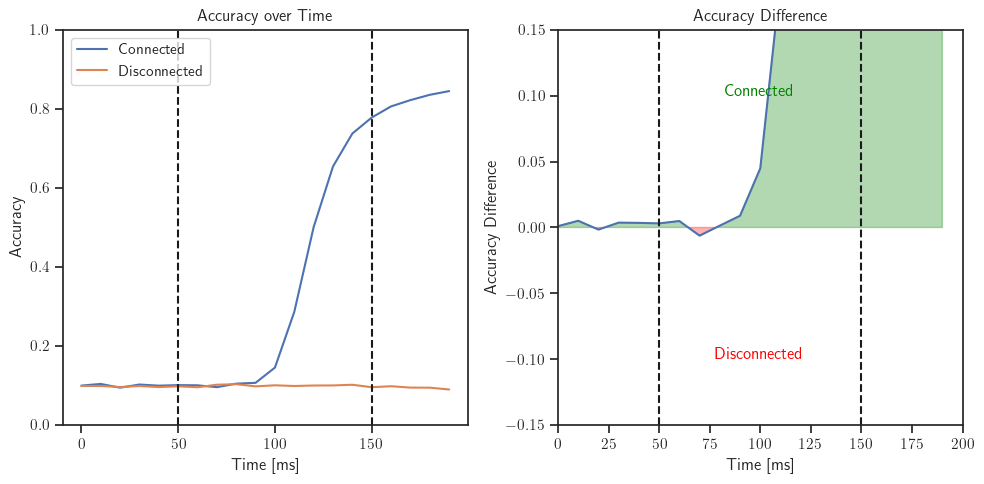

In [165]:
# Create a figure with subplots side by side
time = np.arange(0, 200, 10)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# Plot the accuracy over time in the first subplot
axs[0].plot(time, correct_predictions_connected, label='Connected')
axs[0].plot(time, correct_predictions_disconnected, label='Disconnected')
axs[0].axvline(x=50, color='k', linestyle='--')
axs[0].axvline(x=150, color='k', linestyle='--')
axs[0].set_xlabel('Time [ms]')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim(0, 1)
axs[0].legend(loc='upper left')
axs[0].set_title('Accuracy over Time')

# Plot the accuracy difference in the second subplot
accuracy_difference = correct_predictions_connected - correct_predictions_disconnected
axs[1].plot(time, accuracy_difference, label='Difference')
axs[1].axvline(x=50, color='k', linestyle='--')
axs[1].axvline(x=150, color='k', linestyle='--')
axs[1].fill_between(time, accuracy_difference, where=(accuracy_difference >= 0), interpolate=True, color='green', alpha=0.3)
axs[1].fill_between(time, accuracy_difference, where=(accuracy_difference < 0), interpolate=True, color='red', alpha=0.3)
axs[1].set_xlabel('Time [ms]')
axs[1].set_ylabel('Accuracy Difference')
axs[1].set_xlim(0, 200)
axs[1].set_ylim(-0.15, 0.15)
axs[1].text(100, 0.10, 'Connected', horizontalalignment='center', fontsize=12, color='green')
axs[1].text(100, -0.10, 'Disconnected', horizontalalignment='center', fontsize=12, color='red')
# axs[1].legend(loc='upper left')
axs[1].set_title('Accuracy Difference')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Confusion Matrix Connected:
 [[ 946    2    0    1    2    7   13    2    4    3]
 [   0 1105    1    2    0    3    4    0   12    8]
 [  21   68  769   27   12    4   34   22   36   39]
 [   9   15   10  806    0   54    4   12   34   66]
 [   3    4    3    0  584    1   18    0    2  367]
 [  21   14    2   56   11  668   22    6   25   67]
 [  16   13    3    0   16   20  875    0    4   11]
 [   4   25   23    2    5    2    0  799    2  166]
 [  15   24    1   28    7   25    9    4  743  118]
 [   8    6    0    7   10    1    1    5    7  964]]
Confusion Matrix Disconnected:
 [[240  54 142 177  25  97  26  48  66 105]
 [446  51  78 283  29  84  25  68  40  31]
 [357  72 147 206  29  63  31  44  40  43]
 [352  44 130 230  27  84  28  18  54  43]
 [245  60 252 178   8  56  33  27  43  80]
 [279  55  82 211  14  92  42  20  47  50]
 [280  73 115 211  13  48  19  21  56 122]
 [310  49 205 191  15  88  38  42  67  23]
 [238  68 135 247  28  79  34  31  59  55]
 [296  53 227 194   7

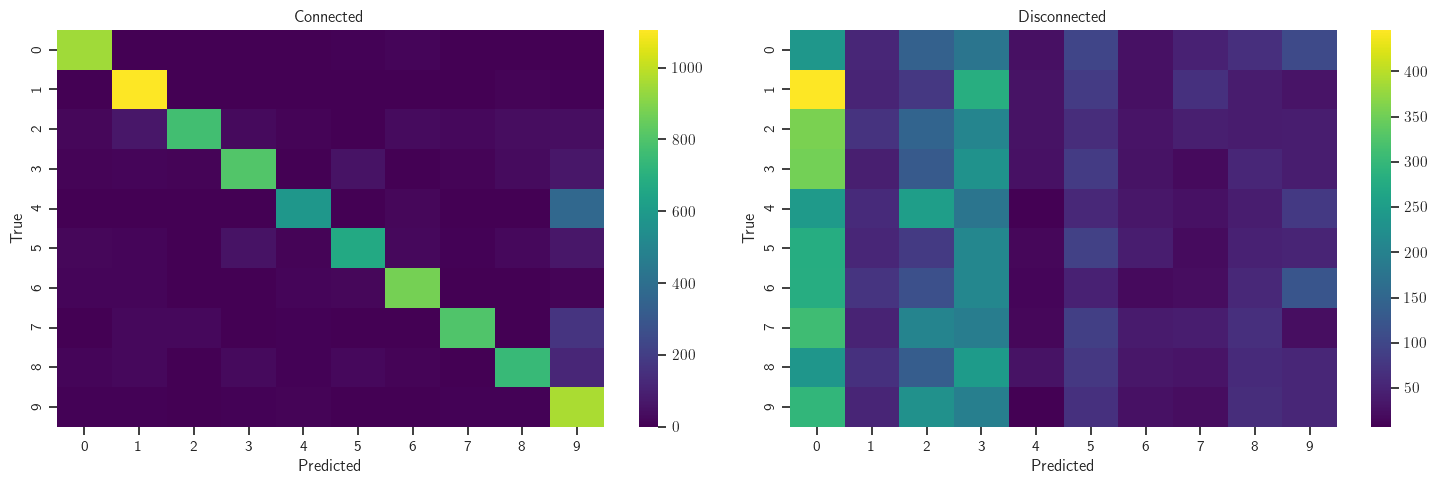

In [16]:
# sum the spikes for the last 5 timestamps
response_spikes_connected = np.sum(spikes_connected[:, -5:, :], axis=1)
response_spikes_disconnected = np.sum(spikes_disconnected[:, -5:, :], axis=1)

p_connected = tf.nn.softmax(response_spikes_connected, axis=-1) # TensorShape([None, 4, 10])
p_disconnected = tf.nn.softmax(response_spikes_disconnected, axis=-1) # TensorShape([None, 4, 10])

predicted_classes_connected = tf.cast(tf.argmax(p_connected, axis=-1), dtype=tf.int32)
predicted_classes_disconnected = tf.cast(tf.argmax(p_disconnected, axis=-1), dtype=tf.int32)

# Flatten the arrays to calculate the confusion matrix
flattened_labels_connected = labels_connected.flatten()
flattened_labels_disconnected = labels_disconnected.flatten()
flattened_predictions_connected = predicted_classes_connected.numpy().flatten()
flattened_predictions_disconnected = predicted_classes_disconnected.numpy().flatten()

# Calculate the confusion matrix for each condition
confusion_matrix_connected = tf.math.confusion_matrix(flattened_labels_connected, flattened_predictions_connected, num_classes=10)
confusion_matrix_disconnected = tf.math.confusion_matrix(flattened_labels_disconnected, flattened_predictions_disconnected, num_classes=10)

print("Confusion Matrix Connected:\n", confusion_matrix_connected.numpy())
print("Confusion Matrix Disconnected:\n", confusion_matrix_disconnected.numpy())

# plot the confusion matrix
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(confusion_matrix_connected, fmt='d', cmap='viridis', ax=axs[0])
axs[0].set_title('Connected')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
sns.heatmap(confusion_matrix_disconnected, fmt='d', cmap='viridis', ax=axs[1])
axs[1].set_title('Disconnected')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
plt.tight_layout()
plt.show()

Accuracy Matrix Connected:
 [0.9653061  0.97356826 0.74515504 0.79801983 0.59470469 0.7488789
 0.91336119 0.77723736 0.76283365 0.95540136]
Accuracy Matrix Disconnected:
 [0.24489796 0.04493392 0.14244185 0.22772278 0.00814664 0.10313901
 0.01983299 0.04085603 0.06057495 0.05351834]


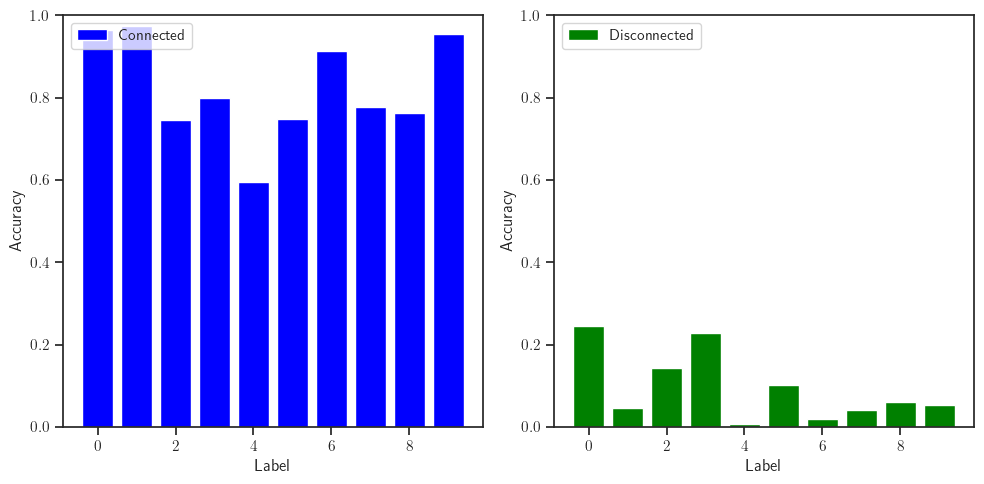

In [17]:
# sum the spikes for the last 5 timestamps
response_spikes_connected = np.sum(spikes_connected[:, -5:, :], axis=1)
response_spikes_disconnected = np.sum(spikes_disconnected[:, -5:, :], axis=1)

p_connected = tf.nn.softmax(response_spikes_connected, axis=-1) # TensorShape([None, 4, 10])
p_disconnected = tf.nn.softmax(response_spikes_disconnected, axis=-1) # TensorShape([None, 4, 10])

predicted_classes_connected = tf.cast(tf.argmax(p_connected, axis=-1), dtype=tf.int32)
predicted_classes_disconnected = tf.cast(tf.argmax(p_disconnected, axis=-1), dtype=tf.int32)

correct_predictions_connected = tf.cast(tf.equal(predicted_classes_connected, labels_connected), dtype=tf.float32)
correct_predictions_disconnected = tf.cast(tf.equal(predicted_classes_disconnected, labels_disconnected), dtype=tf.float32)

# correct_predictions_connected = tf.reduce_mean(correct_predictions_connected, axis=0).numpy()
# correct_predictions_disconnected = tf.reduce_mean(correct_predictions_disconnected, axis=0).numpy()

# Calculate the average accuracy for each class
accuracy_matrix_connected = np.zeros((10,))
accuracy_matrix_disconnected = np.zeros((10,))

for i in range(10):
    mask_connected = tf.equal(labels_connected, i)
    mask_disconnected = tf.equal(labels_disconnected, i)
    
    class_correct_connected = tf.boolean_mask(correct_predictions_connected, mask_connected)
    class_correct_disconnected = tf.boolean_mask(correct_predictions_disconnected, mask_disconnected)
    
    accuracy_matrix_connected[i] = tf.reduce_mean(class_correct_connected).numpy()
    accuracy_matrix_disconnected[i] = tf.reduce_mean(class_correct_disconnected).numpy()

print("Accuracy Matrix Connected:\n", accuracy_matrix_connected)
print("Accuracy Matrix Disconnected:\n", accuracy_matrix_disconnected)

# plot the accuracy over labels
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].bar(np.arange(10), accuracy_matrix_connected, color='blue', label='Connected')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim(0, 1)
axs[0].legend(loc='upper left')
# axs[0].set_title(title_a)

axs[1].bar(np.arange(10), accuracy_matrix_disconnected, color='green', label='Disconnected')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim(0, 1)
axs[1].legend(loc='upper left')
# axs[1].set_title(title_b)

plt.tight_layout()
plt.show()

In [18]:
def compute_rdm(activity_matrix):
    """
    Computes the Representational Dissimilarity Matrix (RDM).
    activity_matrix: (n_trials * n_digits, n_neurons) array with neural responses.
    Returns:
        RDM: (n_trials * n_digits, n_trials * n_digits) dissimilarity matrix.
    """
    return squareform(pdist(activity_matrix, metric='correlation'))  # or 'euclidean'

def plot_mds_comparison(spikes_a, labels_a, spikes_b, labels_b, title_a="MDS A", title_b="MDS B", max_points=2000):
    """
    Creates two subplots comparing MDS representations for two sets of spikes and labels,
    sharing the same colorbar and optionally subsampling points for faster performance.
    
    Parameters:
        spikes_a (array-like): Neural activity matrix for the first dataset (trials x neurons).
        labels_a (array-like): Labels for the first dataset.
        spikes_b (array-like): Neural activity matrix for the second dataset (trials x neurons).
        labels_b (array-like): Labels for the second dataset.
        max_points (int): Maximum number of points to plot (for subsampling).
    """
    # Subsample if the data has too many points
    def subsample(spikes, labels, max_points):
        if spikes.shape[0] > max_points:
            idx = np.random.choice(spikes.shape[0], max_points, replace=False)
            return spikes[idx], labels[idx]
        return spikes, labels

    spikes_a, labels_a = subsample(spikes_a, labels_a, max_points)
    spikes_b, labels_b = subsample(spikes_b, labels_b, max_points)
    # Compute RDMs
    rdm_a = compute_rdm(spikes_a)
    rdm_b = compute_rdm(spikes_b)
    # Prepare MDS (parallelized with n_jobs=-1)
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42, n_jobs=-1)
    coords_a = mds.fit_transform(rdm_a)
    coords_b = mds.fit_transform(rdm_b)
    # Plot side-by-side with a shared colorbar
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
    scatter_a = axes[0].scatter(coords_a[:, 0], coords_a[:, 1], c=labels_a, cmap='tab10', s=2, alpha=0.8)
    scatter_b = axes[1].scatter(coords_b[:, 0], coords_b[:, 1], c=labels_b, cmap='tab10', s=2, alpha=0.8)
    # Titles and labels
    axes[0].set_title(title_a, fontsize=14)
    axes[0].set_xlabel("MDS Dimension 1", fontsize=12)
    axes[0].set_ylabel("MDS Dimension 2", fontsize=12)
    axes[0].set_ylim([-1, 1])
    axes[0].set_xlim([-1, 1])
    axes[1].set_title(title_b, fontsize=14)
    axes[1].set_xlabel("MDS Dimension 1", fontsize=12)
    # Add a single shared colorbar
    cbar = fig.colorbar(scatter_a, ax=axes, location="right", fraction=0.02, pad=0.1)
    cbar.set_label('Digit Labels', fontsize=12)
    # plt.tight_layout()
    plt.show()

In [19]:
for i in range(20):
    print('Time step: ', i*10, ' ms')
    plot_mds_comparison(spikes_connected[:, i, :], labels_connected, 
                    spikes_disconnected[:, i, :], labels_disconnected,
                    title_a="Connected", title_b="Disconnected", max_points=200)

Time step:  0  ms


ValueError: Input X contains NaN.
MDS does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

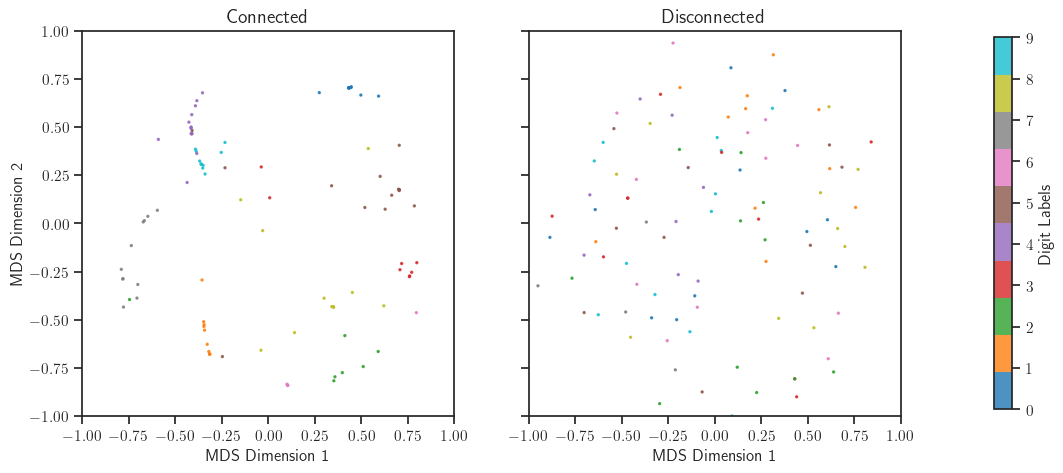

In [21]:
# sum the spikes for the last 5 timestamps
response_spikes_connected = np.sum(spikes_connected[:, -5:, :], axis=1)
response_spikes_disconnected = np.sum(spikes_disconnected[:, -5:, :], axis=1)

plot_mds_comparison(response_spikes_connected, labels_connected, 
                    response_spikes_disconnected, labels_disconnected, 
                    title_a="Connected", title_b="Disconnected", max_points=100)

In [22]:
# Helper function to compute mean activity and RDM
def prepare_rdm(spikes, labels):
    df = pd.DataFrame(spikes)
    df['y'] = labels  # Add the `y` values as a new column
    grouped = df.groupby('y').mean()
    activity_mean = grouped.values
    return compute_rdm(activity_mean)
    # return activity_mean

def plot_rdm_comparison(spikes_a, labels_a, spikes_b, labels_b, title_a="RDM A", title_b="RDM B"):
    """
    Creates two subplots comparing RDM representations for two sets of spikes and labels,
    sharing a single colorbar.
    
    Parameters:
        spikes_a (array-like): Neural activity matrix for the first dataset (trials x neurons).
        labels_a (array-like): Labels for the first dataset.
        spikes_b (array-like): Neural activity matrix for the second dataset (trials x neurons).
        labels_b (array-like): Labels for the second dataset.
        title_a (str): Title for the first subplot.
        title_b (str): Title for the second subplot.
    """    
    # Compute RDMs
    rdm_a = prepare_rdm(spikes_a, labels_a)
    rdm_b = prepare_rdm(spikes_b, labels_b)
    
    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
    
    # Create the heatmaps without individual colorbars
    # vmin, vmax = 0, 1  # Adjust these values based on your data range
    vmin = 0
    vmax = max(rdm_a.max(), rdm_b.max())
    heatmap_a = sns.heatmap(
        rdm_a, 
        ax=axes[0], 
        cmap='RdBu', 
        square=True, 
        cbar=False, 
        xticklabels=range(10), 
        yticklabels=range(10), 
        vmin=vmin, 
        vmax=vmax, 
        annot=False
    )
    axes[0].set_title(title_a, fontsize=16, weight='bold', pad=15)
    axes[0].set_xlabel("Digits (0-9)", fontsize=16)
    axes[0].set_ylabel("Digits (0-9)", fontsize=16)
    axes[0].tick_params(axis='x', labelsize=12)
    axes[0].tick_params(axis='y', labelsize=12)
    
    heatmap_b = sns.heatmap(
        rdm_b, 
        ax=axes[1], 
        cmap='RdBu', 
        square=True, 
        cbar=False, 
        xticklabels=range(10), 
        yticklabels=range(10), 
        vmin=vmin, 
        vmax=vmax, 
        annot=False
    )
    axes[1].set_title(title_b, fontsize=16, weight='bold', pad=15)
    axes[1].set_xlabel("Digits (0-9)", fontsize=16)
    axes[1].set_ylabel("Digits (0-9)", fontsize=16)
    axes[1].tick_params(axis='x', labelsize=12)
    axes[1].tick_params(axis='y', labelsize=12)
    
    # Add a shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax, label='Dissimilarity', orientation='vertical')
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar
    plt.show()


/tmp/ipykernel_151687/2055974753.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


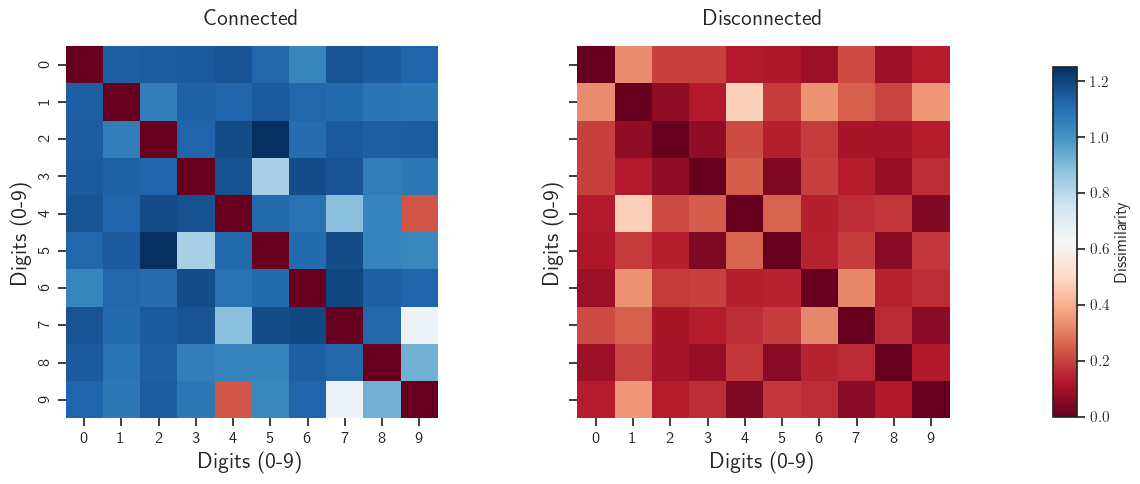

In [23]:
plot_rdm_comparison(response_spikes_connected, labels_connected, response_spikes_disconnected, labels_disconnected, title_a="Connected", title_b="Disconnected")

In [24]:
def plot_rdm_difference(spikes_a, labels_a, spikes_b, labels_b, title="RDM A"):
    """
    Creates two subplots comparing RDM representations for two sets of spikes and labels,
    sharing a single colorbar.
    
    Parameters:
        spikes_a (array-like): Neural activity matrix for the first dataset (trials x neurons).
        labels_a (array-like): Labels for the first dataset.
        spikes_b (array-like): Neural activity matrix for the second dataset (trials x neurons).
        labels_b (array-like): Labels for the second dataset.
        title_a (str): Title for the first subplot.
        title_b (str): Title for the second subplot.
    """    
    # Compute RDMs
    rdm_a = prepare_rdm(spikes_a, labels_a)
    rdm_b = prepare_rdm(spikes_b, labels_b)

    rdm_diff = rdm_a - rdm_b
    
    # Plot side-by-side
    fig, axes = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
    
    # Create the heatmaps without individual colorbars
    # vmin, vmax = 0, 1  # Adjust these values based on your data range
    vmin = -max(rdm_diff.max(), -rdm_diff.min())
    vmax = max(rdm_diff.max(), -rdm_diff.min())
    heatmap_a = sns.heatmap(
        rdm_diff, 
        ax=axes, 
        cmap='RdBu', 
        square=True, 
        cbar=False, 
        xticklabels=range(10), 
        yticklabels=range(10), 
        vmin=vmin, 
        vmax=vmax, 
        annot=False
    )
    axes.set_title(title, fontsize=16, weight='bold', pad=15)
    axes.set_xlabel("Digits (0-9)", fontsize=16)
    axes.set_ylabel("Digits (0-9)", fontsize=16)
    axes.tick_params(axis='x', labelsize=12)
    axes.tick_params(axis='y', labelsize=12)
        
    # Add a shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax, label='Dissimilarity', orientation='vertical')
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar
    plt.show()


/tmp/ipykernel_151687/3200637434.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


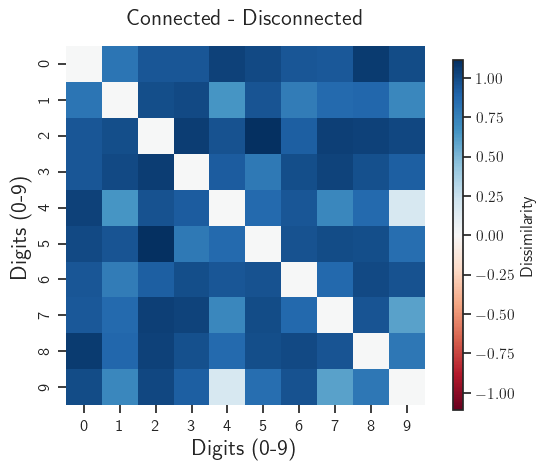

In [25]:
plot_rdm_difference(response_spikes_connected, labels_connected, response_spikes_disconnected, labels_disconnected, title="Connected - Disconnected")

In [26]:
# Compare RDMs
rdm_baseline = prepare_rdm(response_spikes_connected, labels_connected)
rdm_silenced = prepare_rdm(response_spikes_disconnected, labels_disconnected)
correlation = np.corrcoef(rdm_baseline.flatten(), rdm_silenced.flatten())[0, 1]
print(f"RDM correlation between LM intact and silenced: {correlation:.2f}")

RDM correlation between LM intact and silenced: 0.61


In [27]:
connected_dissimilarity_matrix = prepare_rdm(response_spikes_connected, labels_connected)
connected_dissimilarity_matrix2 = np.triu(connected_dissimilarity_matrix, k=1)
connected_dissimilarity_matrix2 = connected_dissimilarity_matrix2[connected_dissimilarity_matrix2 != 0]
np.mean(connected_dissimilarity_matrix2)

1.079697537821648

In [28]:
disconnected_dissimilarity_matrix = prepare_rdm(response_spikes_disconnected, labels_disconnected)
disconnected_dissimilarity_matrix2 = np.triu(disconnected_dissimilarity_matrix, k=1)
disconnected_dissimilarity_matrix2 = disconnected_dissimilarity_matrix2[disconnected_dissimilarity_matrix2 != 0]
np.mean(disconnected_dissimilarity_matrix2)

0.1704508690703273

In [29]:
correlation = np.corrcoef(connected_dissimilarity_matrix2, disconnected_dissimilarity_matrix2)[0, 1]
print(f"RDM correlation between LM intact and silenced: {correlation:.2f}")

RDM correlation between LM intact and silenced: 0.37


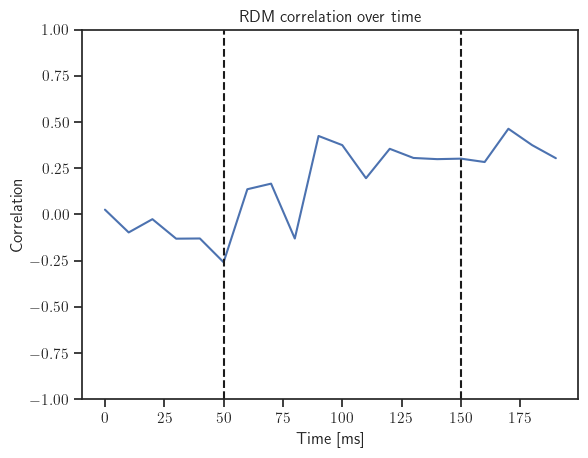

In [30]:
correlations = []
for i in range(20):
    # Compare RDMs
    rdm_baseline = prepare_rdm(spikes_connected[:, i, :], labels_connected)
    rdm_silenced = prepare_rdm(spikes_disconnected[:, i, :], labels_disconnected)
    # correlation = np.corrcoef(rdm_baseline.flatten(), rdm_silenced.flatten())[0, 1]
    # correlations.append(correlation)

    connected_dissimilarity_matrix2 = np.triu(rdm_baseline, k=1)
    connected_dissimilarity_matrix2 = connected_dissimilarity_matrix2[connected_dissimilarity_matrix2 != 0]

    disconnected_dissimilarity_matrix2 = np.triu(rdm_silenced, k=1)
    disconnected_dissimilarity_matrix2 = disconnected_dissimilarity_matrix2[disconnected_dissimilarity_matrix2 != 0]
    correlation = np.corrcoef(connected_dissimilarity_matrix2, disconnected_dissimilarity_matrix2)[0, 1]
    correlations.append(correlation)

plt.plot(time, correlations)
plt.axvline(x=50, color='k', linestyle='--')
plt.axvline(x=150, color='k', linestyle='--')
plt.xlabel('Time [ms]')
plt.ylabel('Correlation')
plt.title('RDM correlation over time')
plt.ylim([-1, 1])
plt.show()


Time step:  0  ms


/tmp/ipykernel_151687/2055974753.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


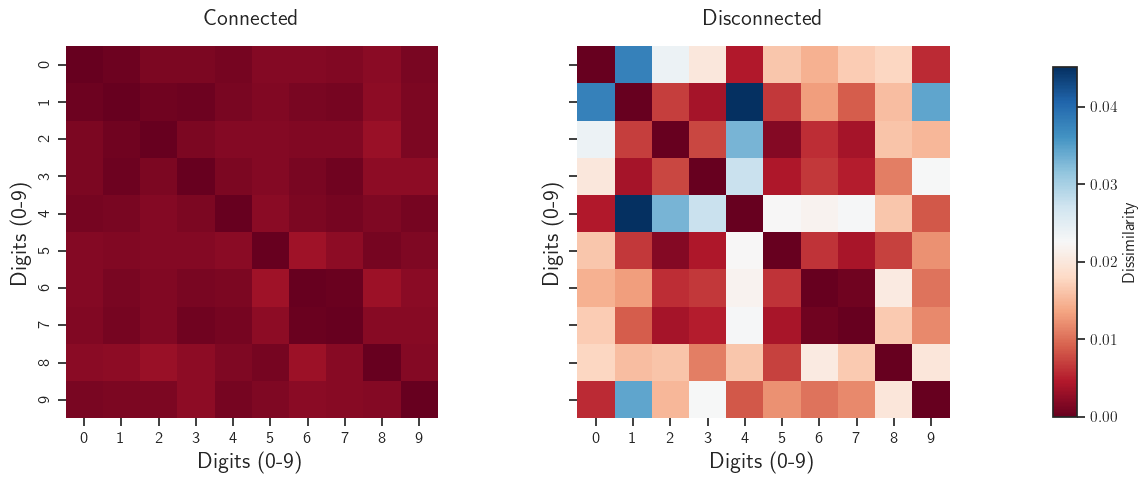

Time step:  10  ms


/tmp/ipykernel_151687/2055974753.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


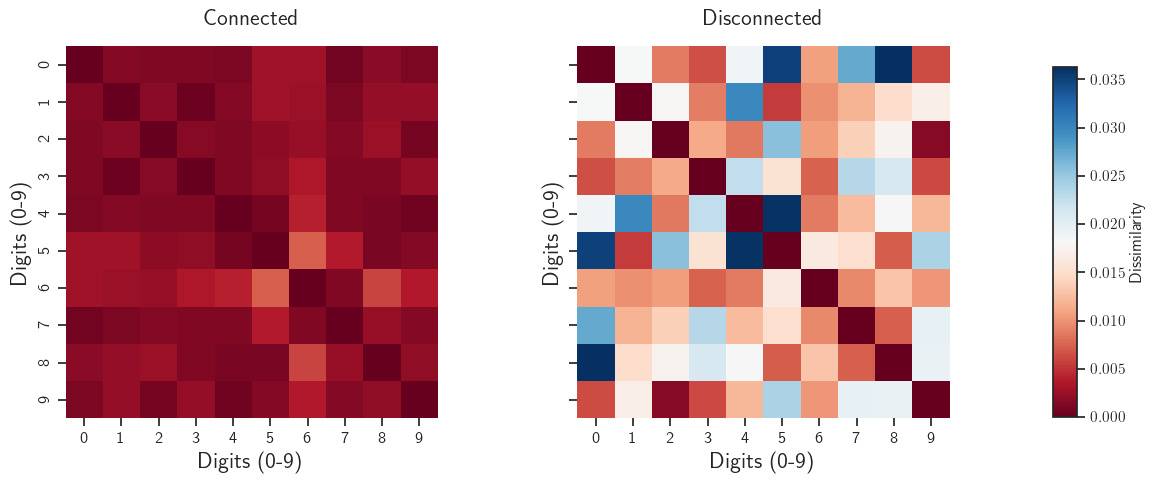

Time step:  20  ms


/tmp/ipykernel_151687/2055974753.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


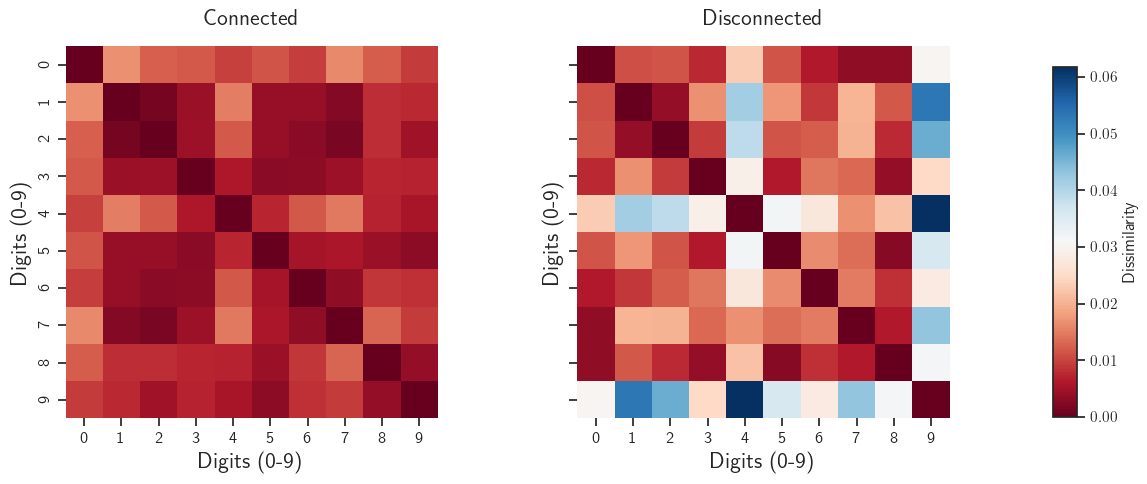

Time step:  30  ms


/tmp/ipykernel_151687/2055974753.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


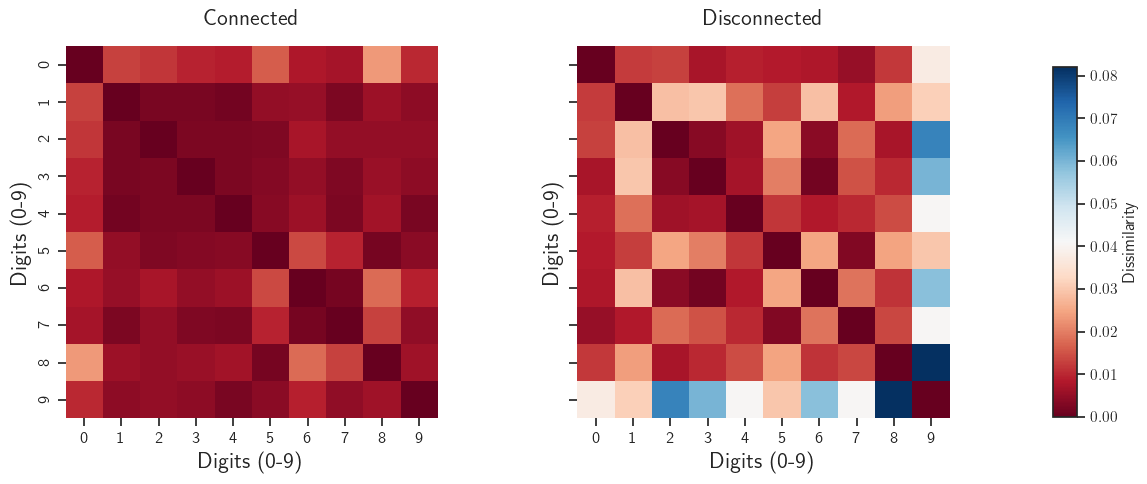

Time step:  40  ms


/tmp/ipykernel_151687/2055974753.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


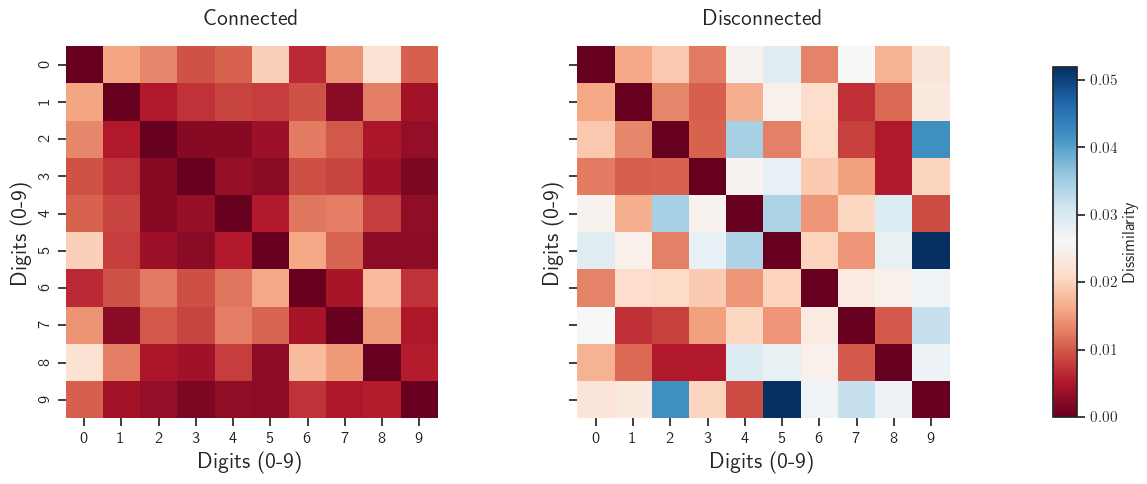

Time step:  50  ms


/tmp/ipykernel_151687/2055974753.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


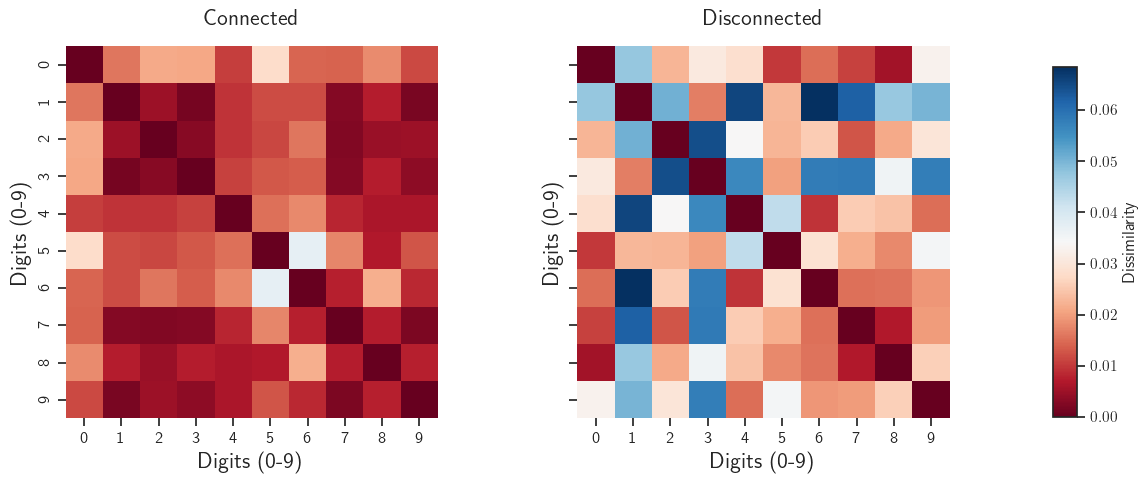

Time step:  60  ms


/tmp/ipykernel_151687/2055974753.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


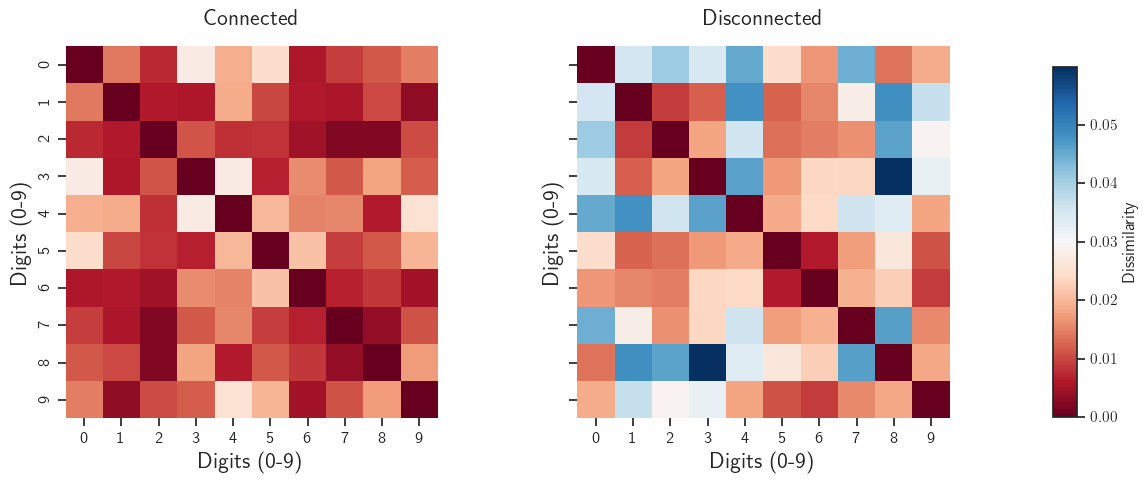

Time step:  70  ms


/tmp/ipykernel_151687/2055974753.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


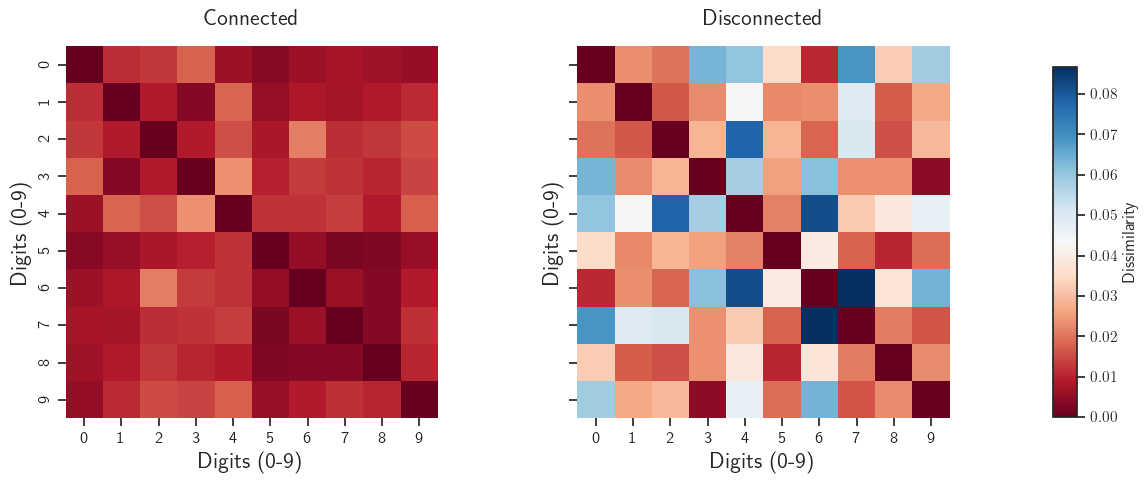

Time step:  80  ms


/tmp/ipykernel_151687/2055974753.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


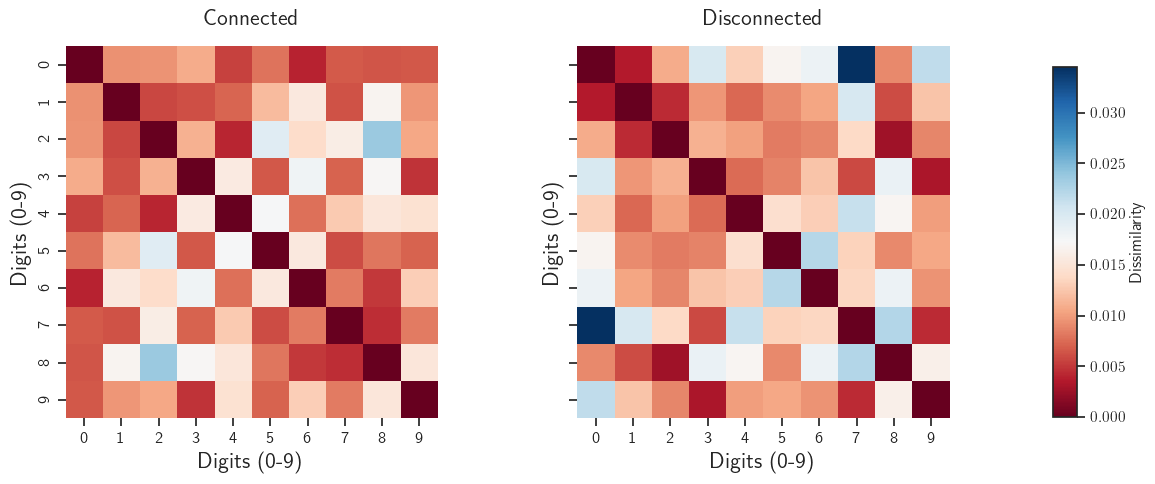

Time step:  90  ms


/tmp/ipykernel_151687/2055974753.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


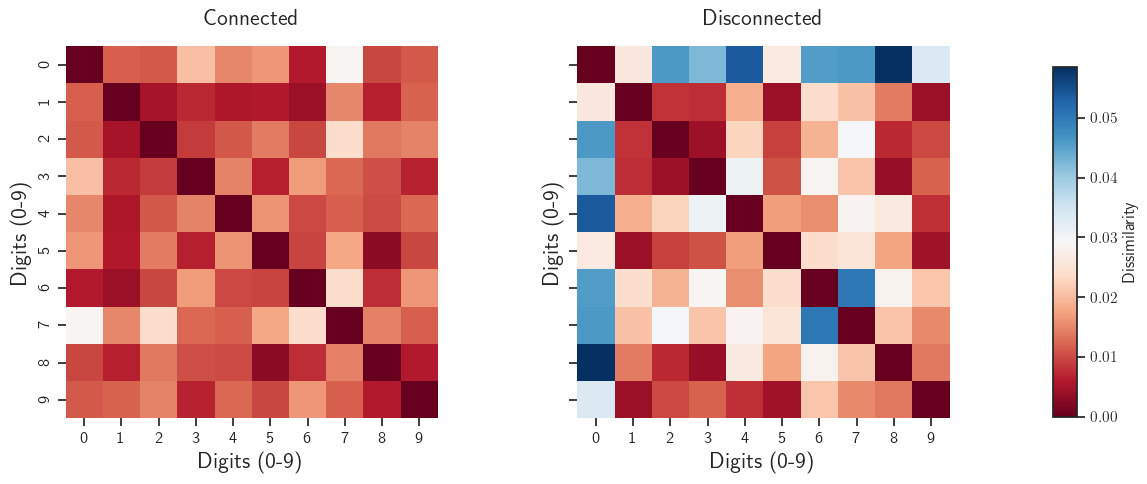

Time step:  100  ms


/tmp/ipykernel_151687/2055974753.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


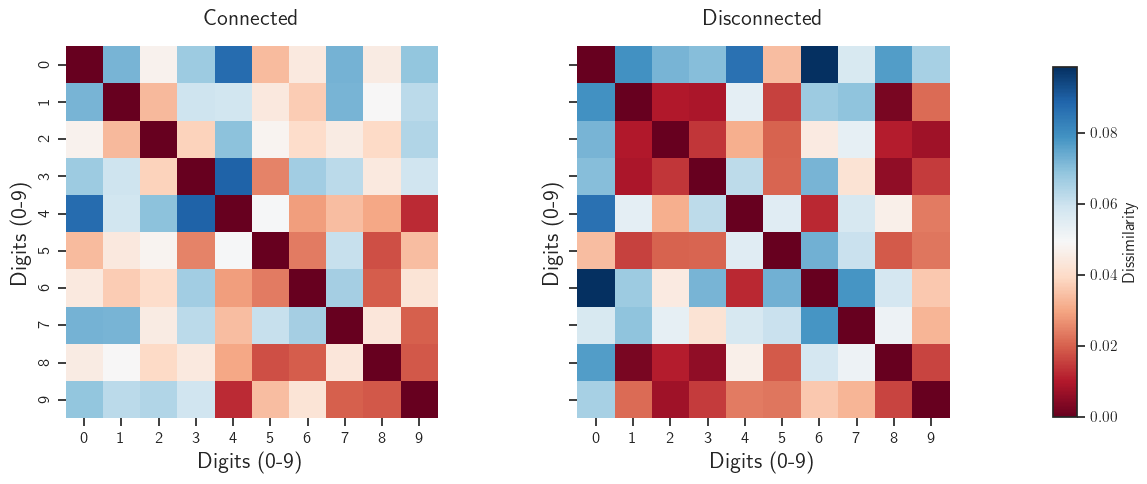

Time step:  110  ms


/tmp/ipykernel_151687/2055974753.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


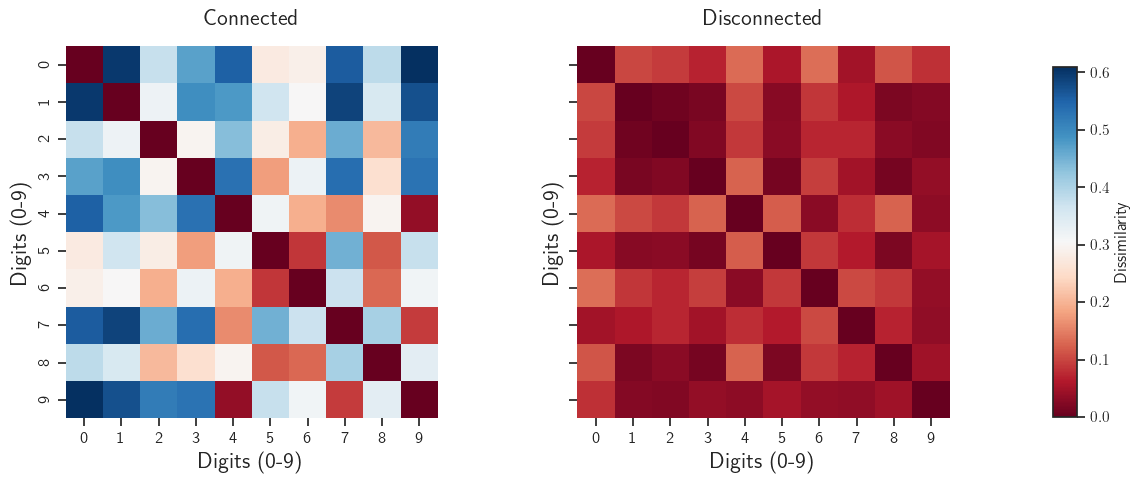

Time step:  120  ms


/tmp/ipykernel_151687/2055974753.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


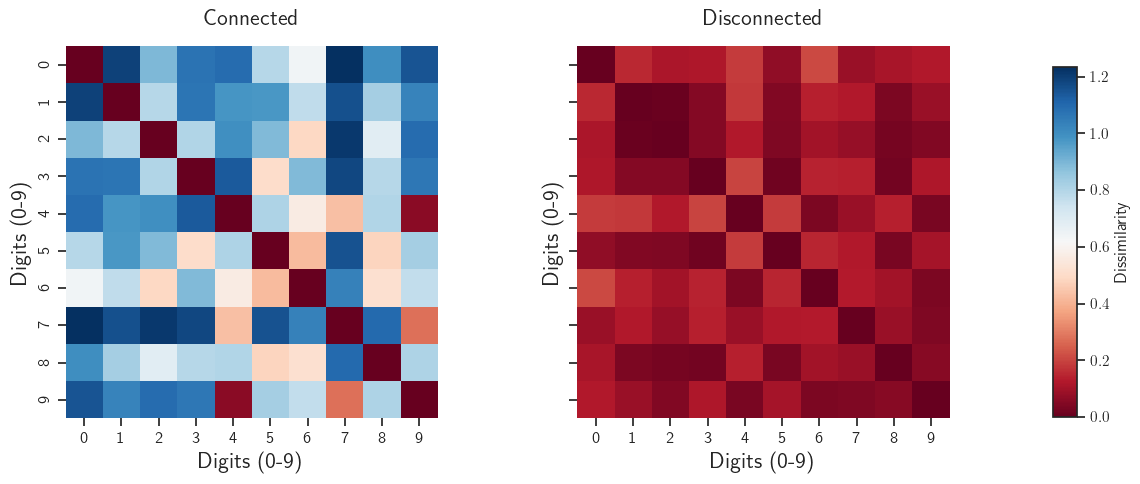

Time step:  130  ms


/tmp/ipykernel_151687/2055974753.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


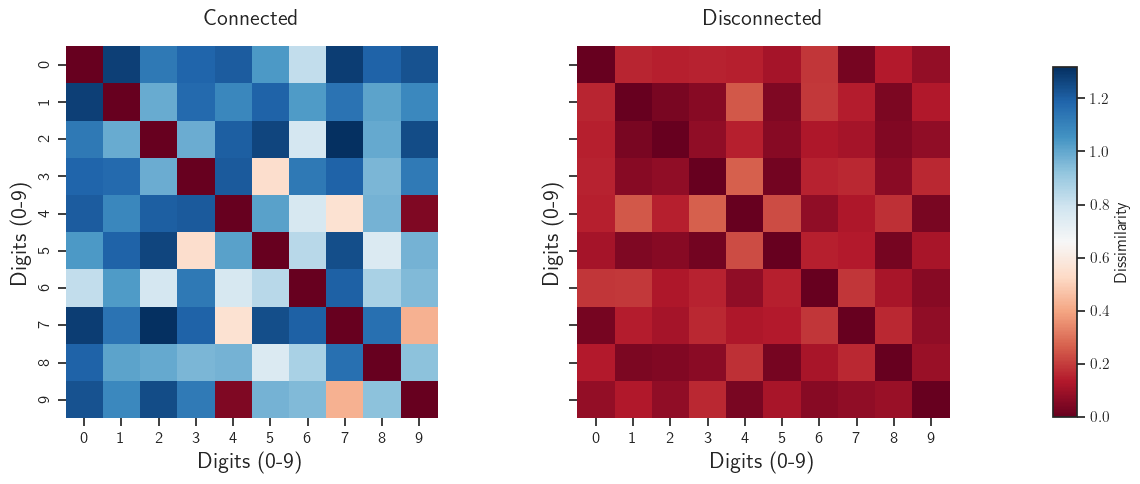

Time step:  140  ms


/tmp/ipykernel_151687/2055974753.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


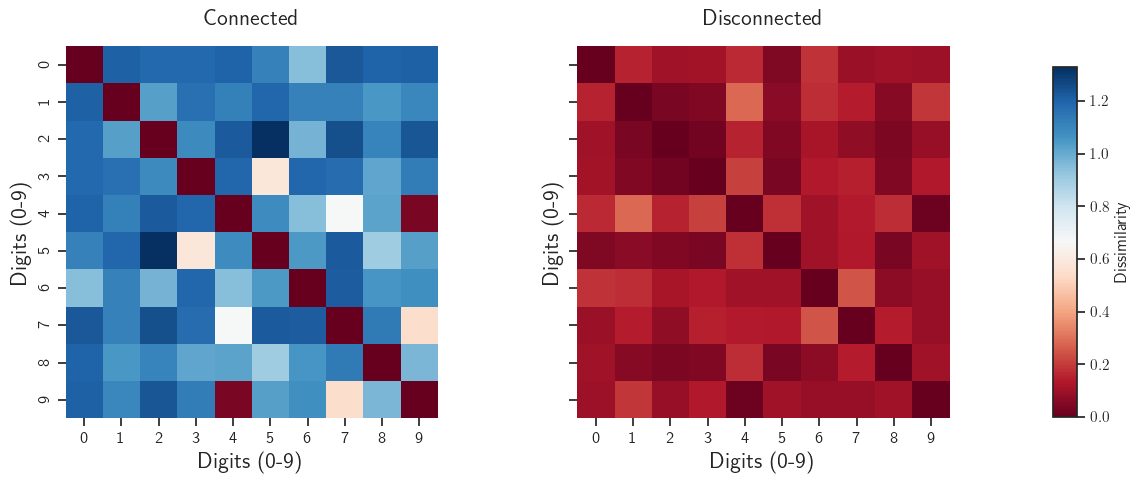

Time step:  150  ms


/tmp/ipykernel_151687/2055974753.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


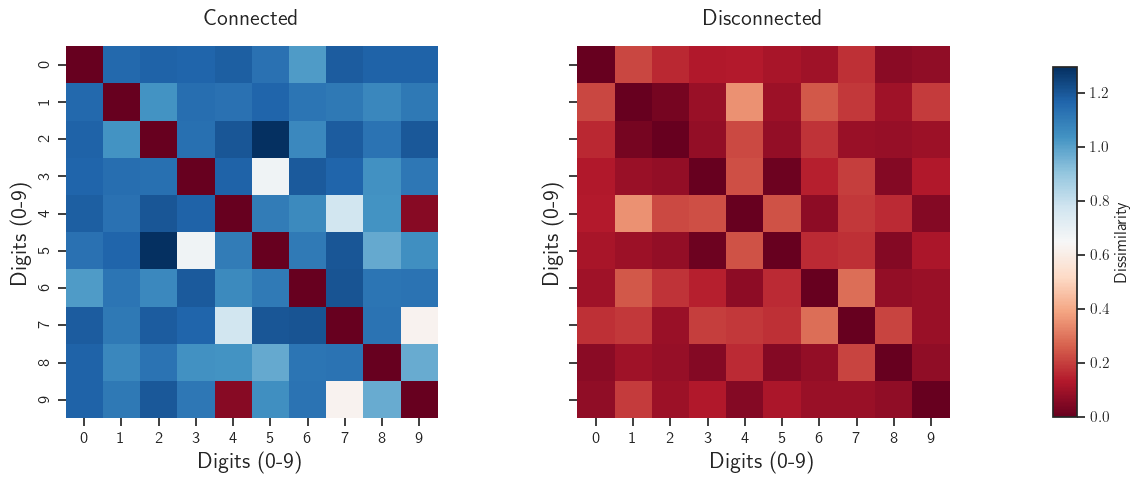

Time step:  160  ms


/tmp/ipykernel_151687/2055974753.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


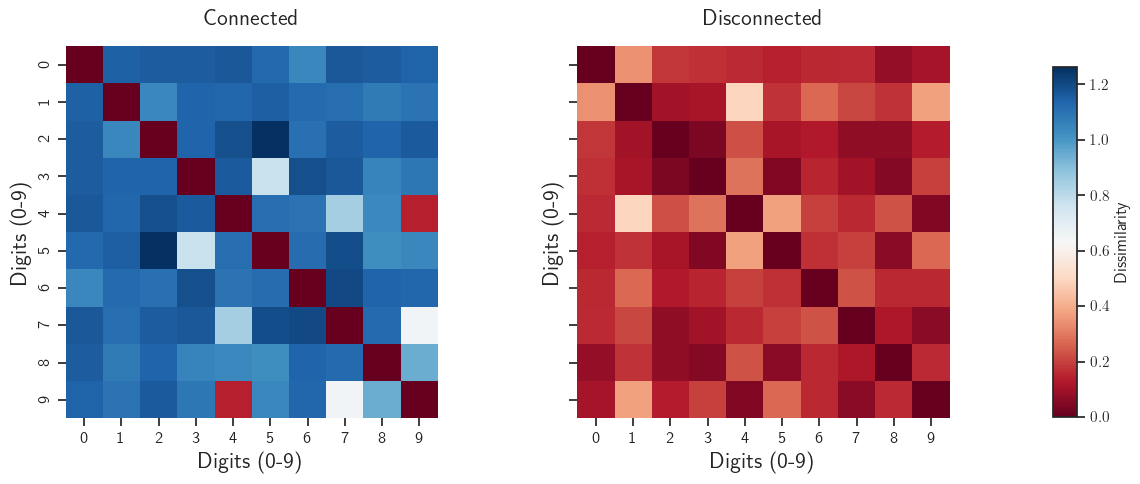

Time step:  170  ms


/tmp/ipykernel_151687/2055974753.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


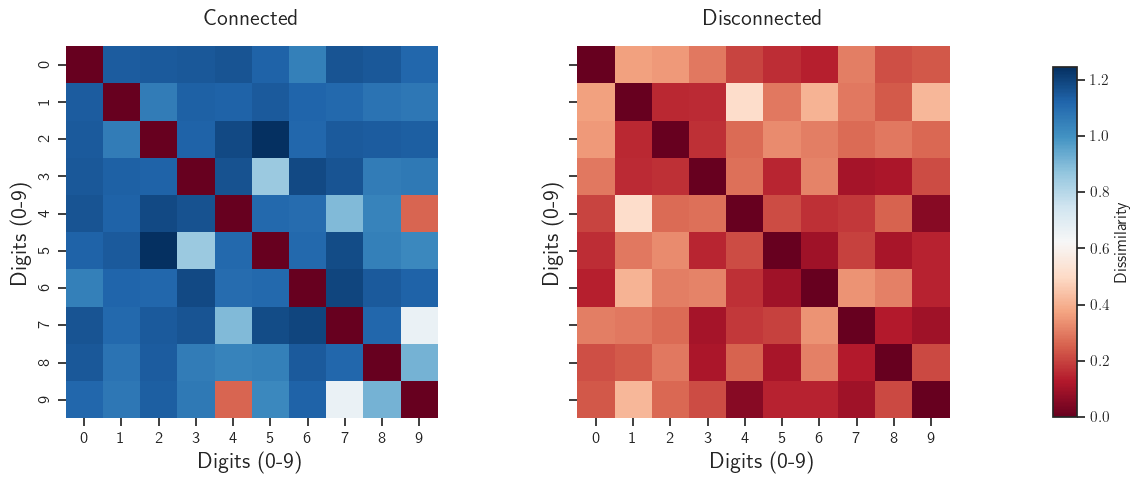

Time step:  180  ms


/tmp/ipykernel_151687/2055974753.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


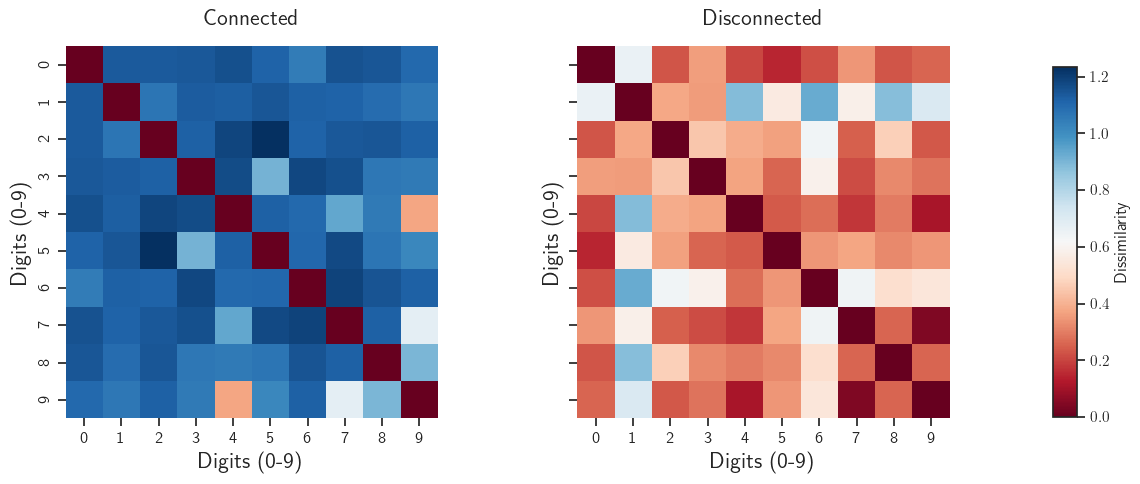

Time step:  190  ms


/tmp/ipykernel_151687/2055974753.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


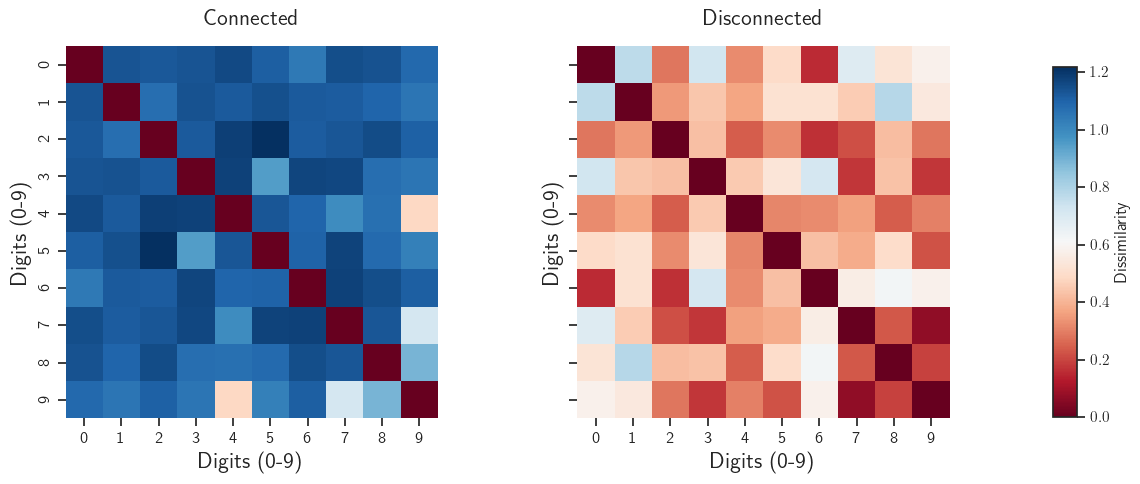

In [31]:
for i in range(20):
    print('Time step: ', i*10, ' ms')
    plot_rdm_comparison(spikes_connected[:, i, :], labels_connected, spikes_disconnected[:, i, :], labels_disconnected, title_a="Connected", title_b="Disconnected")

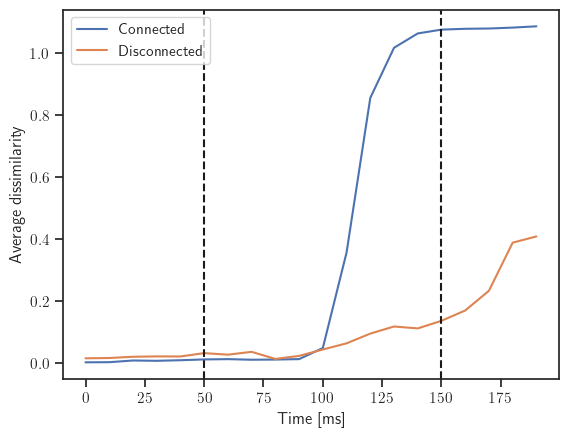

In [32]:
diss_connected = []
diss_disconnected = []
for i in range(20):
    dissimilarity_matrix = prepare_rdm(spikes_connected[:, i, :], labels_connected)
    dissimilarity_matrix2 = np.triu(dissimilarity_matrix, k=1)
    dissimilarity_matrix2 = dissimilarity_matrix2[dissimilarity_matrix2 != 0]
    diss_connected.append(np.mean(dissimilarity_matrix2))

    dissimilarity_matrix = prepare_rdm(spikes_disconnected[:, i, :], labels_disconnected)
    dissimilarity_matrix2 = np.triu(dissimilarity_matrix, k=1)
    dissimilarity_matrix2 = dissimilarity_matrix2[dissimilarity_matrix2 != 0]
    diss_disconnected.append(np.mean(dissimilarity_matrix2))

# plot the trace
plt.plot(time, diss_connected, label='Connected')
plt.plot(time, diss_disconnected, label='Disconnected')
# include vertical lines for the stimulus onset and offset
plt.axvline(x=50, color='k', linestyle='--')
plt.axvline(x=150, color='k', linestyle='--')
plt.xlabel('Time [ms]')
plt.ylabel('Average dissimilarity')
# plt.yscale('log')
# plt.ylim(0, 1)
plt.legend(loc='upper left')
plt.show()